In [17]:
# Assignment 1: Fast Trajectory Replanning
# Authors: Brian Yi, Mahesh Annapureddy

In [187]:
# ipyplubish: ipynb to latex to pdf converter
# !nbpublish -pdf -lb -pbug assignment1.ipynb

INFO:ipypublish:started ipypublish v0.10.10 at Sun Mar  1 23:25:07 2020
INFO:ipypublish:logging to: C:\Users\brian\OneDrive\Desktop\work\school\rutgers\2020-spring\intro-to-AI\converted\assignment1.nbpub.log
INFO:ipypublish:running for ipynb(s) at: assignment1.ipynb
INFO:ipypublish:with conversion configuration: latex_ipypublish_main
INFO:nbmerge:Reading notebook
INFO:ipypublish:finding conversion configuration: latex_ipypublish_main
INFO:ipypublish:loading conversion configuration
INFO:ipypublish:creating exporter
INFO:ipypublish:creating template and loading filters
INFO:ipypublish:creating process configuration
INFO:ipypublish:running nbconvert
INFO:root:splitting outputs into separate cells
INFO:resolve_links:resolving external file paths in ipub metadata to: assignment1.ipynb
INFO:captions:extracting caption cells
INFO:write-text-file:writing stream to file: C:\Users\brian\OneDrive\Desktop\work\school\rutgers\2020-spring\intro-to-AI\converted\assignment1.tex
INFO:write-resource-fi

INFO:pdf-export:latexmk: ("C:\Users\brian\AppData\Local\Programs\MiKTeX 2.9\tex/latex/zref\zref-base.sty
INFO:pdf-export:latexmk: "))
INFO:pdf-export:latexmk: ("C:\Users\brian\AppData\Local\Programs\MiKTeX 2.9\tex/latex/needspace\needspac
INFO:pdf-export:latexmk: e.sty")
INFO:pdf-export:latexmk: ("C:\Users\brian\AppData\Local\Programs\MiKTeX 2.9\tex/latex/mdframed\md-frame-
INFO:pdf-export:latexmk: 1.mdf"))
INFO:pdf-export:latexmk: ("C:\Users\brian\AppData\Local\Programs\MiKTeX 2.9\tex/latex/geometry\geometry.
INFO:pdf-export:latexmk: sty"
INFO:pdf-export:latexmk: ("C:\Users\brian\AppData\Local\Programs\MiKTeX 2.9\tex/generic/iftex\ifvtex.sty
INFO:pdf-export:latexmk: ")
INFO:pdf-export:latexmk: ("C:\Users\brian\AppData\Local\Programs\MiKTeX 2.9\tex/latex/geometry\geometry.
INFO:pdf-export:latexmk: cfg"))
INFO:pdf-export:latexmk: ("C:\Users\brian\AppData\Local\Programs\MiKTeX 2.9\tex/latex/cleveref\cleveref.
INFO:pdf-export:latexmk: sty") (assignment1.aux
INFO:pdf-export:latexmk: 
INFO:

In [1]:
# nbconverter (backup converter)
# %%capture
# !jupyter nbconvert --to pdf --template hidecode assignment1.ipynb

# Setup Environments

**Frameworks**

We use the following main frameworks: numpy, pandas, matplotlib, and heapq. Numpy and pandas are used for data collecting and processing purposes. Matplotlib is used to visualize the maze worlds. Heapq is used for the binary heap data structure.

In [1]:
# Frameworks used
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import heapq as hp
from ipypublish import nb_setup
from copy import deepcopy

**Data Structures**

We use the following data structures: 2D array, linked list, and binary heap. We use a 2D array to contain the information for the maze world. We opt for a linked list structure for our A\* algorithm closed lists for O(1) runtime when adding new nodes while still being able to track the entire closed list for algorithm debug purposes. We use a binary heap for our A\* algorithm open lists to implement the priority queue that sorts the states in our desired order. We also choose a binary heap since its implementation allows us to easily remove the highest priority state, which is the primary function of our open list.

In [2]:
# Linkedlist for closed list
class Linked_list:
    
    def __init__(self):
        self.head = None

# Node class for closed list
class Node:
    
    def __init__(self, data):
        self.data = data
        self.prev = None
        self.next = None

**Maze World / States**

Each maze world is a 101 x 101 sized grid where each state (cell) has a 30% of being blocked. Each maze world also contains a randomly generated spawn and target that is never blocked. While measuring algorithm runtimes, we set the spawn and target states to [5,5] and [95, 95] respectively for less variance in our results. We do not choose the corners since it is more likely that the surrounding blocks can be blocked, resulting in no available path. Each state represent an individual cell on the map, and contains both the necessary information for our A\* algorithms to run and our agent's knowledge of the map. Note that our state class differs slightly between our three algorithms due to different heuristic update implementations.

In [3]:
# Maze class for our 101 x 101 sized grid worlds
class Maze:
    
    def __init__(self, rows, columns, seed):
        self.rows = rows
        self.columns = columns
        self.grid, self.spawn, self.target = self.create_grid(seed)
        self.g_max = 0
    
    def create_grid(self, seed):
        # Initialize maze grid
        grid = [[1 for j in range(self.columns)] for i in range(self.rows)]

        # Determine which states (cells) are blocked
        np.random.seed(seed)
        grid_blocked = np.random.uniform(size=(self.rows, self.columns))
        
        for i in range(self.rows):
            for j in range(self.columns):
                if grid_blocked[i][j] <= 0.3:
                    grid[i][j] = 0           
        
        # Marking spawn and target
        spawn = [5, 5]
        target = [95, 95]
        grid[spawn[0]][spawn[1]] = 3
        grid[target[0]][target[1]] = 2
        
#         # Marking randomly generated spawn and targets
#         spawn = [-1, -1]
#         target = [-1, -1]
#         while (spawn[0] == target[0] and spawn[1] == target[1]):
#             spawn[0] = np.random.randint(0, self.rows)
#             spawn[1] = np.random.randint(0, self.columns)
#             target[0] = np.random.randint(0, self.rows)
#             target[1] = np.random.randint(0, self.columns)
#         grid[spawn[0]][spawn[1]] = 3
#         grid[target[0]][target[1]] = 2

        return grid, spawn, target

# State Class is included in the individual A* algorithms

**Methods**

We have three main A\* algorithms: Forward A\*, Backward A\*, and Adaptive A\*. Running each A\* method will output whether the agent reaches the target, the runtime, and a visualization of the path the agent takes. Even though all three methods use the same 50 generated maze worlds, each method consists of three parts that differ in implementation. Each A\* algorithm method consists of a state class, compute_path method, and main method that corresponds to the respective algorithm. The compute_path method is essentially the A\* algorithm that determines the best path from agent to target state at any point in time. The main method uses the path calculated from the A\* algorithm, and moves the agent accordingly as well as handles the output of the overall A\* algorithm. In addition to our three main algorithms, we also came up with three print methods, `print_grid`, `print_agent_fpath`, and `print_agent_map` that we used to validate results. `print_grid` prints any maze so that we can see where the spawn state, target state, and blocked states are. `print_agent_fpath` prints out the final path the agent takes throughout the maze to get from the spawn state to target state; this visualization includes all of the blocked states in the maze. `print_agent_map` prints the current agent map at any given compute_path() iteration; this visualization shows only the blocked states the agent has encountered along with all the expanded states.

In [4]:
# Forward A* algorithm (3 parts)
def forward_a(maze):
    
    # Part 1: State class
    class State:

        def __init__(self, row, column, maze):
            self.coord = [row, column]
            self.maze = maze
            self.g = None
            self.h = abs(row-maze.target[0]) + abs(column-maze.target[1])
            self.f = None
            self.pointer = None
            self.search = 0
            
            # What the agent sees at each iteration of A*
            self.agent_map = 1
        
        # Single value used to compare state priorities
        @property
        def priority(self):
            return self.maze.g_max*self.f - self.g
        
        def init_f(self):
            self.f = self.g + self.h

        # For binary heap open list to compare states
        def __lt__(self, other):
            if self.priority == other.priority:
                return np.random.uniform() > .5
            else:
                return self.priority < other.priority

    # Part 2: compute_path method
    def compute_path():
        path_len = 0
        maze.g_max = 0
        
        # Loop until target state g-value <= least f-value of open list
        while state_target.g > open_list[0].f:
            path_len += 1
            
            # Removing the state with the least f-value
            if path_len == 1:
                closed_list.next = Node(hp.heappop(open_list))
            else:            
                node_insert = Node(hp.heappop(open_list))
                closed_list.next.prev = node_insert
                node_insert.next = closed_list.next
                closed_list.next = node_insert
            
            # Counter for expanded states
            total_expanded_states_count.append(1)
            
            # For each child of the expanded state, do the following
            for child, direction in zip(range(4), [[-1, 0], [1, 0], [0, 1], [0, -1]]): 
                row = closed_list.next.data.coord[0] + direction[0]
                column = closed_list.next.data.coord[1] + direction[1]
                
                # Check that the successor state is not outside the maze
                if row < 0 or row >= maze.rows or column < 0 or column >= maze.columns:
                    continue
                # Skip successor state if it is a blocked state
                elif total_states[row][column].agent_map == 0:
                    continue
                # Select child as successor state
                else:                                       
                    state_succ = total_states[row][column]
                
                # Check if successor state is already part of this current compute_path iteration
                if state_succ.search < counter:
                    state_succ.g = float('inf')
                    state_succ.search = counter
                
                # Sets the parent pointer and adjusts g-value for successor state
                if state_succ.g > closed_list.next.data.g + 1:
                    state_succ.g = closed_list.next.data.g + 1
                    state_succ.pointer = closed_list.next.data
                    
                    # Find the highest max g-value for state priorities
                    if maze.g_max < state_succ.g:
                        maze.g_max = state_succ.g
                    
                    # Checks and removes if sucessor state is already in open list
                    for state, i in zip(open_list, range(len(open_list))):
                        if state_succ.coord == state.coord:
                            open_list[i] = open_list[0]
                            hp.heappop(open_list)
                            hp.heapify(open_list)
                    
                    # Initialize f value for successor state
                    state_succ.init_f()
                    
                    # Add successor state to open list and reorder accordingly
                    hp.heappush(open_list, state_succ)
                    hp.heapify(open_list)
            
            # Break if open list is empty
            if len(open_list) == 0:
                break

    # Part 3: Main method
    success = True # Whether our agent reaches target
    counter = 0 # How many steps our agent takes
    
    # All the possible states are first assumed as unblocked by our agent
    total_states = ([[State(i, j, maze) for j in range(maze.columns)]
                     for i in range(maze.rows)])
    total_expanded_states_count = []
    
    # Initiate spawn and target states in our total states
    state_spawn = total_states[maze.spawn[0]][maze.spawn[1]]
    state_target = total_states[maze.target[0]][maze.target[1]]
    state_spawn.agent_map = 3
    state_target.agent_map = 2
    
    # Initialize neighboring states of original spawn
    for child, direction in zip(range(4), [[-1, 0], [1, 0], [0, 1], [0, -1]]): 
        row = state_spawn.coord[0] + direction[0]
        column = state_spawn.coord[1] + direction[1]

        # Check that state is not outside the maze
        if row < 0 or row >= maze.rows or column < 0 or column >= maze.columns:
            continue
        else:
            # agent_map (what the agent sees) is updated
            total_states[row][column].agent_map = maze.grid[row][column]
            
    # For visualization of full agent path
    full_path = []
    full_path.append(state_spawn.coord)
    
    # Loop while spawn state doesn't move to target state
    while state_spawn.coord != state_target.coord:

        # As spawn state moves each iteration (counter), add to final_path
        counter += 1
      
        # Initiate spawn, target, open/closed lists
        state_spawn.g = 0
        state_spawn.init_f()
        state_spawn.search = counter
        state_target.g = float('inf')
        state_target.search = counter
        open_list = []
        closed_list = Linked_list()
        
        # Push first value into open list and run compute_path
        hp.heappush(open_list, state_spawn)
        compute_path()
        
        # When agent doesn't reach the target
        if len(open_list) == 0:
            success = False
            break    
        
        # Using pointers create current iteration path
        state_curr = open_list[0]
        path = []
        path.append(state_curr.coord)
        while state_curr.coord != state_spawn.coord:
            state_curr = state_curr.pointer
            path.append(state_curr.coord)
       
        # Move agent (state_spawn) until blocked cell
        for i, coord in zip(range(len(path)-1), path):
            
            # Check that the next state isn't blocked
            if maze.grid[path[-i-2][0]][path[-i-2][1]] != 0:
                
                # Move agent into the new state and add to full path
                state_spawn = total_states[path[-i-2][0]][path[-i-2][1]]
                full_path.append(state_spawn.coord)
                
                # For all neighboring states of the do the following
                for child, direction in zip(range(4), [[-1, 0], [1, 0], [0, 1], [0, -1]]): 
                    row = state_spawn.coord[0] + direction[0]
                    column = state_spawn.coord[1] + direction[1]

                    # Check that neighboring state is not outside the maze
                    if row < 0 or row >= maze.rows or column < 0 or column >= maze.columns:
                        continue
                    else:
                        # Update unblocked state on agent_map
                        total_states[row][column].agent_map = maze.grid[row][column]
            else:
                # Update blocked state on agent_map
                total_states[path[-i-2][0]][path[-i-2][1]].agent_map = 0
                break

    # Printing results and returning
    if success == True:
        reach_target = "Yes"
        #print("Your agent reached the target!")
    else:
        reach_target = "No"
        #print("Your agent couldn't reach the target...")
    expanded_states = len(total_expanded_states_count)
    #print('Total expanded states:', expanded_states)
    
    return reach_target, expanded_states, full_path

In [5]:
""" Backward A* algorithm (3 Parts)
For this algorithm, view state_spawn as the state where the algorithm starts.
Thus, the state_spawn is really the state_target and vice versa. Following
this concept, state_target is the state that represents the agent and will move.
""" 
def backward_a(maze):
    
    # Part 1: State class
    class State:

        def __init__(self, row, column, maze):
            self.coord = [row, column]
            self.maze = maze
            self.g = None
            self.f = None
            self.pointer = None
            self.search = 0
            
            # What the agent sees at each iteration of A*
            self.agent_map = 1
        
        # h-value needs to update as the maze target moves
        @property
        def h(self):
            return (abs(self.coord[0]-self.maze.target[0])
                    + abs(self.coord[1]-self.maze.target[1]))
        
        # Single value used to compare state priorities
        @property
        def priority(self):
            return self.maze.g_max*self.f - self.g
        
        def init_f(self):
            self.f = self.g + self.h

        # For binary heap open list to compare states
        def __lt__(self, other):
            if self.priority == other.priority:
                return np.random.uniform() > .5
            else:
                return self.priority < other.priority

    # Part 2: compute_path method
    def compute_path():
        path_len = 0
        maze.g_max = 0
        
        # Loop until target state g-value <= least f-value of open list
        while state_target.g > open_list[0].f:
            path_len += 1

            # Removing least f-value state from open list and add to closed list
            if path_len == 1:
                closed_list.next = Node(hp.heappop(open_list))
            else:            
                node_insert = Node(hp.heappop(open_list))
                closed_list.next.prev = node_insert
                node_insert.next = closed_list.next
                closed_list.next = node_insert
            
            # Counter for expanded states
            total_expanded_states_count.append(1)

            # For each child of the expanded state, do the following
            for child, direction in zip(range(4), [[-1, 0], [1, 0], [0, 1], [0, -1]]): 
                row = closed_list.next.data.coord[0] + direction[0]
                column = closed_list.next.data.coord[1] + direction[1]

                # Check that the successor state is not outside the maze
                if row < 0 or row >= maze.rows or column < 0 or column >= maze.columns:
                    continue
                # Skip successor state if it is a blocked state
                elif total_states[row][column].agent_map == 0:
                    continue   
                # Select child as successor state
                else:
                    state_succ = total_states[row][column]
                 
                # Check if successor state is already part of this current compute_path iteration
                if state_succ.search < counter:
                    state_succ.g = float('inf')
                    state_succ.search = counter
                
                # Sets the parent pointer and adjusts g-value for successor state
                if state_succ.g > closed_list.next.data.g + 1:
                    state_succ.g = closed_list.next.data.g + 1
                    state_succ.pointer = closed_list.next.data
                    
                    # Find the highest max g-value for state priorities
                    if maze.g_max < state_succ.g:
                        maze.g_max = state_succ.g
                        
                    # Checks and removes if sucessor state is already in open list
                    for state, i in zip(open_list, range(len(open_list))):
                        if state_succ.coord == state.coord:
                            open_list[i] = open_list[0]
                            hp.heappop(open_list)
                            hp.heapify(open_list)
                        
                    # Initialize f value for successor state
                    state_succ.init_f()
                    
                    # Add successor state to open list and reorder accordingly
                    hp.heappush(open_list, state_succ)
                    hp.heapify(open_list)
            
            # Break if open list is empty
            if len(open_list) == 0:
                break

    # Part 3: Main method
    
    # Switching maze target and maze spawn since this is backwards algorithm
    temp_coord = maze.target
    maze.target = maze.spawn
    maze.spawn = temp_coord
    
    success = True # Whether our agent reaches target
    counter = 0 # How many steps our agent takes
    
    # All the possible states are first assumed as unblocked by our agent
    total_states = ([[State(i, j, maze) for j in range(maze.columns)]
                     for i in range(maze.rows)])
    total_expanded_states_count = []
    
    # Initiate spawn and target states in our total states
    state_spawn = total_states[maze.spawn[0]][maze.spawn[1]]
    state_target = total_states[maze.target[0]][maze.target[1]]
    state_spawn.agent_map = 2
    state_target.agent_map = 3
    
    # Initialize neighboring states of original spawn (now state target)
    for child, direction in zip(range(4), [[-1, 0], [1, 0], [0, 1], [0, -1]]): 
        row = state_target.coord[0] + direction[0]
        column = state_target.coord[1] + direction[1]

        # Check that state is not outside the maze
        if row < 0 or row >= maze.rows or column < 0 or column >= maze.columns:
            continue
        else:
            # agent_map (what the agent sees) is updated
            total_states[row][column].agent_map = maze.grid[row][column]
            
    # For visualization of full agent path
    full_path = []
    full_path.append(state_target.coord)

    # Loop while spawn state doesn't move to target state
    while state_spawn.coord != state_target.coord:
        
        # As spawn state moves each iteration (counter), add to final_path
        counter += 1
        
        # Initiate spawn, target, open/closed lists
        state_spawn.g = 0
        state_spawn.init_f()
        state_spawn.search = counter
        state_target.g = float('inf')
        state_target.search = counter
        open_list = []
        closed_list = Linked_list()

        # Push first value into open list and run compute_path
        hp.heappush(open_list, state_spawn)
        compute_path()
        
        # When agent doesn't reach the target
        if len(open_list) == 0:
            success = False
            break
        
        # Using pointers to get back to spawn state
        state_curr = open_list[0]
        path = []
        path.append(state_curr.coord)       
        while state_curr.coord != state_spawn.coord:
            state_curr = state_curr.pointer
            path.append(state_curr.coord)
        
        # Move agent, set spawn state to new state, and rerun
        for i, coord in zip(range(len(path)-1), path):
            
            # Check that the next state isn't blocked
            if maze.grid[path[i+1][0]][path[i+1][1]] != 0:
                
                # Move agent into the new state and add to full path
                state_target = total_states[path[i+1][0]][path[i+1][1]]
                maze.target = path[i+1]
                full_path.append(state_target.coord)
                
                # For all neighboring states do the following
                for child, direction in zip(range(4), [[-1, 0], [1, 0], [0, 1], [0, -1]]): 
                    row = state_target.coord[0] + direction[0]
                    column = state_target.coord[1] + direction[1]

                    # Check that neighboring state is not outside the maze
                    if row < 0 or row >= maze.rows or column < 0 or column >= maze.columns:
                        continue
                    else:
                        # Update unblocked state on agent_map
                        total_states[row][column].agent_map = maze.grid[row][column]
            else:
                # Update blocked state on agent_map
                total_states[path[i+1][0]][path[i+1][1]].agent_map = 0
                break
                
    # Resetting maze target and spawn for print purposes
    temp_coord = maze.target
    maze.target = maze.spawn
    maze.spawn = temp_coord

    # Printing results and returning
    if success == True:
        reach_target = "Yes"
        #print("Your agent reached the target!")
    else:
        reach_target = "No"
        #print("Your agent couldn't reach the target...")
    expanded_states = len(total_expanded_states_count)
    #print('Total expanded states:', expanded_states)
    
    return reach_target, expanded_states, full_path

In [6]:
# Adaptive A* algorithm (3 parts)
def adaptive_a(maze):

    # Part 1: State class
    class State:

        def __init__(self, row, column, maze):
            self.coord = [row, column]
            self.maze = maze
            self.g = None
            self.h = abs(row-maze.target[0]) + abs(column-maze.target[1])
            self.f = None
            self.pointer = None
            self.search = 0
            self.agent_map = 1 # What the agent sees at each iteration of A*
        
        def init_f(self):
            self.f = self.g + self.h
        
        # Single value used to compare state priorities
        @property
        def priority(self):
            return self.maze.g_max*self.f - self.g

        # For binary heap open list to compare states
        def __lt__(self, other):
            if self.priority == other.priority:
                return np.random.uniform() > .5
            else:
                return self.priority < other.priority

    # Part 2: compute_path method
    def compute_path():
        path_len = 0
        maze.g_max = 0
        
        # Loop until target state g-value <= least f-value of open list
        while state_target.g > open_list[0].f:
            path_len += 1
            
            # Removing the state with the least f-value
            if path_len == 1:
                closed_list.next = Node(hp.heappop(open_list))
            else:            
                node_insert = Node(hp.heappop(open_list))
                closed_list.next.prev = node_insert
                node_insert.next = closed_list.next
                closed_list.next = node_insert
            
            # Counter for expanded states
            total_expanded_states_count.append(1)
            
            # For each child of the expanded state, do the following
            for child, direction in zip(range(4), [[-1, 0], [1, 0], [0, 1], [0, -1]]): 
                row = closed_list.next.data.coord[0] + direction[0]
                column = closed_list.next.data.coord[1] + direction[1]
                
                # Check that the successor state is not outside the maze
                if row < 0 or row >= maze.rows or column < 0 or column >= maze.columns:
                    continue
                # Skip successor state if it is a blocked state
                elif total_states[row][column].agent_map == 0:
                    continue 
                # Select child as successor state
                else:                                       
                    state_succ = total_states[row][column]
                
                # Check if successor state is already part of this current compute_path iteration
                if state_succ.search < counter:
                    state_succ.g = float('inf')
                    state_succ.search = counter
                
                # Sets the parent pointer and adjusts g-value for successor state
                if state_succ.g > closed_list.next.data.g + 1:
                    state_succ.g = closed_list.next.data.g + 1
                    state_succ.pointer = closed_list.next.data #ERROR COULD BE HERE
                    
                    # Find the highest max g-value for state priorities
                    if maze.g_max < state_succ.g:
                        maze.g_max = state_succ.g
                        
                    # Checks and removes if sucessor state is already in open list
                    for state, i in zip(open_list, range(len(open_list))):
                        if state_succ.coord == state.coord:
                            open_list[i] = open_list[0]
                            hp.heappop(open_list)
                            hp.heapify(open_list)

                    # Initialize f value for successor state
                    state_succ.init_f()
                    
                    # Add successor state to open list and reorder accordingly
                    hp.heappush(open_list, state_succ)
                    hp.heapify(open_list)
            
            # Break if open list is empty
            if len(open_list) == 0:
                break

    # Part 3: Main method

    success = True # Whether our agent reaches target
    counter = 0 # How many steps our agent takes
    
    # All the possible states are first assumed as unblocked by our agent
    total_states = ([[State(i, j, maze) for j in range(maze.columns)]
                     for i in range(maze.rows)])
    total_expanded_states_count = []
    curr_expanded_states_count = 0
    
    # Initiate spawn and target states in our total states
    state_spawn = total_states[maze.spawn[0]][maze.spawn[1]]
    state_target = total_states[maze.target[0]][maze.target[1]]
    state_spawn.agent_map = 3
    state_target.agent_map = 2
    
    # Initialize neighboring states of original spawn
    for child, direction in zip(range(4), [[-1, 0], [1, 0], [0, 1], [0, -1]]): 
        row = state_spawn.coord[0] + direction[0]
        column = state_spawn.coord[1] + direction[1]

        # Check that state is not outside the maze
        if row < 0 or row >= maze.rows or column < 0 or column >= maze.columns:
            continue
        else:
            # agent_map (what the agent sees) is updated
            total_states[row][column].agent_map = maze.grid[row][column]
            
    # For visualization of full agent path
    full_path = []
    full_path.append(state_spawn.coord)
    
    # Loop while spawn state doesn't move to target state
    while state_spawn.coord != state_target.coord:
        
        # As spawn state moves each iteration (counter), add to final_path
        counter += 1
      
        # Initiate spawn, target, open/closed lists
        state_spawn.g = 0
        state_spawn.init_f()
        state_spawn.search = counter
        state_target.g = float('inf')
        state_target.search = counter
        open_list = []
        closed_list = Linked_list()
        
        # Push first value into open list and run compute_path
        hp.heappush(open_list, state_spawn)
        compute_path()
        
        # When agent doesn't reach the target
        if len(open_list) == 0:
            success = False
            break    

        # Using pointers create current iteration path
        state_curr = open_list[0]
        path = []
        path.append(state_curr.coord)
        while state_curr.coord != state_spawn.coord:
            state_curr = state_curr.pointer
            path.append(state_curr.coord)
        
        # Move agent (state_spawn) until blocked cell
        for i, coord in zip(range(len(path)-1), path):
            
            # Check that the next state isn't blocked
            if maze.grid[path[-i-2][0]][path[-i-2][1]] != 0:
                
                # Move agent into the new state and add to full path
                state_spawn = total_states[path[-i-2][0]][path[-i-2][1]]
                full_path.append(state_spawn.coord)
                
                # For all neighboring states of the do the following
                for child, direction in zip(range(4), [[-1, 0], [1, 0], [0, 1], [0, -1]]): 
                    row = state_spawn.coord[0] + direction[0]
                    column = state_spawn.coord[1] + direction[1]

                    # Check that neighboring state is not outside the maze
                    if row < 0 or row >= maze.rows or column < 0 or column >= maze.columns:
                        continue
                    else:
                        # Update unblocked state on agent_map
                        total_states[row][column].agent_map = maze.grid[row][column]
            else:
                # Update blocked state on agent_map
                total_states[path[-i-2][0]][path[-i-2][1]].agent_map = 0
                break

        # Update h-values of expanded states
        current_node = closed_list.next
        state_goal_g = open_list[0].g
        curr_expanded_states_count = (len(total_expanded_states_count)
                                         - curr_expanded_states_count)
        for i in range(curr_expanded_states_count):
            current_node.data.h = state_goal_g - current_node.data.g
            current_node = current_node.next
        curr_expanded_states_count = len(total_expanded_states_count)
    
    # Printing results and returning
    if success == True:
        reach_target = "Yes"
        #print("Your agent reached the target!")
    else:
        reach_target = "No"
        #print("Your agent couldn't reach the target...")
    
    expanded_states = len(total_expanded_states_count)
    #print('Total expanded states:', expanded_states)
    
    return reach_target, expanded_states, full_path

In [14]:
# Print maze methods:

# Print initial maze
def print_grid(maze):
        arr_print_np = np.asarray(maze.grid)
        plt.figure(figsize=(16, 8))
        plt.imshow(arr_print_np, cmap='viridis')

# Prints full path agent takes
def print_agent_fpath(maze, full_path):
    maze1 = deepcopy(maze)
    
    # Setting every step yellow
    for state in full_path:
        maze1.grid[state[0]][state[1]] = 3
        
    # Setting target_state to green
    if maze.target == full_path[-1]:
        maze1.grid[full_path[-1][0]][full_path[-1][1]] = 2
    
    # Print through matplotlib
    grid_path_np = np.asarray(maze1.grid)
    plt.figure(figsize=(16, 8))
    plt.imshow(grid_path_np, cmap='viridis')

# Prints agent map at any compute_path() iteration:
def print_agent_map(maze, total_states, path, state_spawn, algorithm):
    
    # Agent map
    agent_map = ([[1 for j in range(len(total_states[0]))]
                  for i in range(len(total_states))])
    backward_marker = [0, 0]
    
    # Copies agent_map into an array for visualization
    for i in range(len(total_states)):
        for j in range(len(total_states[0])):
            if i == maze.spawn[0] and j == maze.spawn[1]:
                    agent_map[i][j] = 1
            else:
                if algorithm == 'backward' and total_states[i][j].agent_map == 3:
                    agent_map[i][j] = 1
                    backward_marker = [i, j]
                else:
                    agent_map[i][j] = total_states[i][j].agent_map
    
    # Add path to agent_map
    for i in range(len(path)):
        agent_map[path[i][0]][path[i][1]] = 3
    
    # Creating original maze
    grid = maze.grid
    grid[maze.spawn[0]][maze.spawn[1]] = 1
    grid[state_spawn.coord[0]][state_spawn.coord[1]] = 3
    if algorithm == 'backward':
        grid[backward_marker[0]][backward_marker[1]] = 1
        agent_map[maze.target[0]][maze.target[1]] = 2
    
    # Convert mazes and visualize
    maze_np = np.asarray(grid)
    grid_path_np = np.asarray(agent_map)
 
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(grid_path_np, cmap='viridis')
    ax[1].imshow(maze_np, cmap='viridis')
    plt.tight_layout();

# Understanding the Methods

## East or North

**Explain in your report why the first move of the agent (yellow) for the example search problem from Figure 2.1 (below) is to the east rather than the north given that the agent does not know initially which cells are blocked. Target state is in green.**

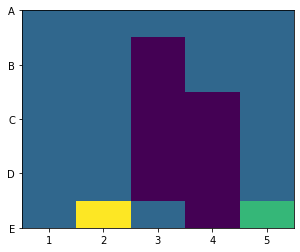

In [25]:
grid = [[1 for j in range(5)] for i in range(5)]
grid[1][2] = 0
grid[2][2] = 0
grid[3][2] = 0
grid[2][3] = 0
grid[3][3] = 0
grid[4][3] = 0
grid[4][1] = 3
grid[4][4] = 2
grid_np = np.asarray(grid)

fig, ax = plt.subplots()
ax.imshow(grid_np)
ax.set(xticks=np.arange(0, 5, step=1),
       xticklabels=['1', '2', '3', '4', '5'],
       yticks=np.arange(0, 5, step=1),
       yticklabels=['A', 'B', 'C', 'D', 'E']);

Given A is the start state and T is the goal state. Initially, the agent does not know which cells are blocked. Each state has 3 values, which are g(s),h(s) and f(s).

* g(s) :- g-value is the length of the shortest path from the start state to state s (present state) found by the A* search.
* h(s) :- h-value is the heuristic manually defined by the user. Here we are using Manhattan distance as the h-value.
* f(s) :- f-value estimates the distance from start state to goal state via current state.
    
Now we perform A* search from start state (A) to goal state (T). We push A (E2 cell) into the open list since it is the start state and we expand A (E2) and add its neighbour cells to the open list which are E1, E3, D2 cells. we move state A (E2) into the closed list as it is already expanded. Now we calculate the f-values of each cell that is in the open list. We choose the smallest f-value cell as the next cell to expand. Open list contains the following 3 cells:

* cell E1 :-  g(E1) = 1    h(E1) = 4    f(E1)= g(E1) + h(E1) = 1 + 4 = 5
* cell E3 :-  g(E3) = 1    h(E3) = 2    f(E3)= g(E3) + h(E3) = 1 + 2 = 3
* cell D2 :-  g(D2) = 1    h(D2) = 4    f(D2)= g(D2) + h(D2) = 1 + 4 = 5

Cell E3 has the smallest f-value among all the cells in the open list so we expand cell E3. We add E3's neighbours, D3 and E4, into the open list. We move cell E3 into the closed list as it is already expanded. Since E2 is already expanded and is in the closed list, we will not put it into the open list again. Open list contains the following 4 cells:

* cell E1 :-  g(E1) = 1    h(E1) = 4    f(E1)= g(E1) + h(E1) = 1 + 4 = 5
* cell D2 :-  g(D2) = 1    h(D2) = 4    f(D2)= g(D2) + h(D2) = 1 + 4 = 5
* cell D3 :-  g(D3) = 2    h(D3) = 3    f(D3)= g(D3) + h(D3) = 2 + 3 = 5
* cell E4 :-  g(E4) = 2    h(E4) = 2    f(E4)= g(E4) + h(E4) = 2 + 2 = 4

Cell E4 has the smallest f-value among all the cells in the open list so we will expand cell E4. We push cell E4 neighbours into the open list, which are D4 and E5 (Goal state). We move cell E4 into the closed list as it is already expanded. Since E3 is already expanded and is in the closed list, we will not put it into the open list again. Open list contains the following 5 cells:

* cell E1 :-  g(E1) = 1    h(E1) = 4    f(E1)= g(E1) + h(E1) = 1 + 4 = 5
* cell D2 :-  g(D2) = 1    h(D2) = 4    f(D2)= g(D2) + h(D2) = 1 + 4 = 5
* cell D3 :-  g(D3) = 2    h(D3) = 3    f(D3)= g(D3) + h(D3) = 2 + 3 = 5
* cell D4 :-  g(D4) = 3    h(D4) = 2    f(E4)= g(D4) + h(D4) = 3 + 2 = 5
* cell E5 :-  g(E5) = 3    h(E5) = 1    f(E5)= g(E5) + h(E5) = 3 + 1 = 4

Cell E5 (goal state) has the smallest f-value among all the cells in the open list so we expand E5. Since it is the goal state(T), A* search stops here. Path found by the A* search is:

* E2(A) --> E3 --> E4 --> E5(T)

Since the agent does not know which cells are blocked or not, the agent follows this path found by A* search and moves to the east initially.

## Finite Maze Worlds and Target Discovery

**This project argues that the agent is guarunteed to reach the target if it is not separated from it by blocked cells. Give a convincing argument that the agent in finite gridworlds indeed either reaches the target or discovers that this is impossible in finite time. Prove that the number of moves of the agent until it reaches the target or discovers that this is impossible is bounded from above by the number of unblocked cells squared.**

Given that the agent is in finite gridworlds, this means there are a finite number of cells. These cells can be either blocked or unblocked. The agent moves only in the four compass directions north, west, south, east to its neighbouring cell given that it is unblocked. We find the shortest unblocked path using A* search and then move the agent along this path. If the agent encounters a blocked state, we increase the action costs of the blocked cell and restart the A* search with the new agent location. If there is any blocked region in the gridworld, the agent is outside this region and will never enter since it can see that the region is blocked. Similarly, for every unblocked region, the agent can traverse through its entirety. Thus, given that a path exists, the agent finds the shortest path to the goal state given it is a finite gridworld. If no path exists, the agent discovers that it is impossible to reach the goal state.

A* search never expands a cell that is already expanded, so it will never put duplicate expanded cells into the closed list. As a result, A* search never enters an infinite loop. In every case, the agent in finite gridworlds is guaranteed to reach the target or discover that no path exists.

Assume that total number of unblocked cells in the given gridworld is N. The whole execution of repeated forward A* or repeated backward A* mainly considers the two following functions:

* compute_path() :- Finds path from the current state to goal state if it exists using the current knowledge of the gridworld.
* main method :- We move the agent along the path that is found by compute_path(). If a cell is blocked, we increase the action costs of the corresponding states and rerun compute_path().

Now, each iteration of the compute_path() takes at most N moves since we do not expand each cell more than once. Let the number of states our agent travels through each iteration of computepath() as M. The worst case scenario is that compute_path() expands every unblocked cell and the agent travels along this path. 
$$M \le N$$        

Once the path is found, the agent moves along this path. If the agent is blocked, then we recompute the shortest path. The worst case scenario is that each time the agent tries to move along the path, it gets blocked after one step so that each time we have to rerun compute_path(). Let's assume the number of times the agent is blocked or compute_path() is executed as I. Since the number of blocked cells is always less than or equal to N:
$$I \le N$$
Using the above two equations we get,
$$MI \le N^2$$
N is total number of unblocked cells in the gridworld.                                                     
M is number of moves agent travels during each iteration.                   
I is the number of times compute_path() is run.          
MI is total number of moves travelled by agent.          
Thus, the number of moves the agent takes until it reaches the target or discovers that no path exists is bounded from above by the number of unblocked cells squared.

# The Effects of Ties

In [17]:
# Forward A* algorithm where tie breakers are broken for the smaller g-value (3 parts)
def forward_a2(maze):
    
    # Part 1: State class
    class State:

        def __init__(self, row, column, maze):
            self.coord = [row, column]
            self.maze = maze
            self.g = None
            self.h = abs(row-maze.target[0]) + abs(column-maze.target[1])
            self.f = None
            self.pointer = None
            self.search = 0
            
            # What the agent sees at each iteration of A*
            self.agent_map = 1
        
        def init_f(self):
            self.f = self.g + self.h

        # For binary heap open list to compare states
        def __lt__(self, other):
            if self.f == other.f:
                if self.g == other.g:
                    return np.random.uniform() > .5
                else:
                    return self.g < other.g
            else:
                return self.f < other.f

    # Part 2: compute_path method
    def compute_path():
        path_len = 0
        maze.g_max = 0
        
        # Loop until target state g-value <= least f-value of open list
        while state_target.g > open_list[0].f:
            path_len += 1
            
            # Removing the state with the least f-value
            if path_len == 1:
                closed_list.next = Node(hp.heappop(open_list))
            else:            
                node_insert = Node(hp.heappop(open_list))
                closed_list.next.prev = node_insert
                node_insert.next = closed_list.next
                closed_list.next = node_insert
            
            # Counter for expanded states
            total_expanded_states_count.append(1)
            
            # For each child of the expanded state, do the following
            for child, direction in zip(range(4), [[-1, 0], [1, 0], [0, 1], [0, -1]]): 
                row = closed_list.next.data.coord[0] + direction[0]
                column = closed_list.next.data.coord[1] + direction[1]
                
                # Check that the successor state is not outside the maze
                if row < 0 or row >= maze.rows or column < 0 or column >= maze.columns:
                    continue
                # Skip successor state if it is a blocked state
                elif total_states[row][column].agent_map == 0:
                    continue
                # Select child as successor state
                else:                                       
                    state_succ = total_states[row][column]
                
                # Check if successor state is already part of this current compute_path iteration
                if state_succ.search < counter:
                    state_succ.g = float('inf')
                    state_succ.search = counter
                
                # Sets the parent pointer and adjusts g-value for successor state
                if state_succ.g > closed_list.next.data.g + 1:
                    state_succ.g = closed_list.next.data.g + 1
                    state_succ.pointer = closed_list.next.data
                    
                    # Find the highest max g-value for state priorities
                    if maze.g_max < state_succ.g:
                        maze.g_max = state_succ.g
                    
                    # Checks and removes if sucessor state is already in open list
                    for state, i in zip(open_list, range(len(open_list))):
                        if state_succ.coord == state.coord:
                            open_list[i] = open_list[0]
                            hp.heappop(open_list)
                            hp.heapify(open_list)
                    
                    # Initialize f value for successor state
                    state_succ.init_f()
                    
                    # Add successor state to open list and reorder accordingly
                    hp.heappush(open_list, state_succ)
                    hp.heapify(open_list)
            
            # Break if open list is empty
            if len(open_list) == 0:
                break

    # Part 3: Main method
    
    success = True # Whether our agent reaches target
    counter = 0 # How many steps our agent takes
    
    # All the possible states are first assumed as unblocked by our agent
    total_states = ([[State(i, j, maze) for j in range(maze.columns)]
                     for i in range(maze.rows)])
    total_expanded_states_count = []
    
    # Initiate spawn and target states in our total states
    state_spawn = total_states[maze.spawn[0]][maze.spawn[1]]
    state_target = total_states[maze.target[0]][maze.target[1]]
    state_spawn.agent_map = 3
    state_target.agent_map = 2
    
    # Initialize neighboring states of original spawn
    for child, direction in zip(range(4), [[-1, 0], [1, 0], [0, 1], [0, -1]]): 
        row = state_spawn.coord[0] + direction[0]
        column = state_spawn.coord[1] + direction[1]

        # Check that state is not outside the maze
        if row < 0 or row >= maze.rows or column < 0 or column >= maze.columns:
            continue
        else:
            # agent_map (what the agent sees) is updated
            total_states[row][column].agent_map = maze.grid[row][column]
            
    # For visualization of full agent path
    full_path = []
    full_path.append(state_spawn.coord)
    
    # Loop while spawn state doesn't move to target state
    while state_spawn.coord != state_target.coord:

        # As spawn state moves each iteration (counter), add to final_path
        counter += 1
      
        # Initiate spawn, target, open/closed lists
        state_spawn.g = 0
        state_spawn.init_f()
        state_spawn.search = counter
        state_target.g = float('inf')
        state_target.search = counter
        open_list = []
        closed_list = Linked_list()
        
        # Push first value into open list and run compute_path
        hp.heappush(open_list, state_spawn)
        compute_path()
        
        # When agent doesn't reach the target
        if len(open_list) == 0:
            success = False
            break    
        
        # Using pointers create current iteration path
        state_curr = open_list[0]
        path = []
        path.append(state_curr.coord)
        while state_curr.coord != state_spawn.coord:
            state_curr = state_curr.pointer
            path.append(state_curr.coord)
       
        # Move agent (state_spawn) until blocked cell
        for i, coord in zip(range(len(path)-1), path):
            
            # Check that the next state isn't blocked
            if maze.grid[path[-i-2][0]][path[-i-2][1]] != 0:
                
                # Move agent into the new state and add to full path
                state_spawn = total_states[path[-i-2][0]][path[-i-2][1]]
                full_path.append(state_spawn.coord)
                
                # For all neighboring states of the do the following
                for child, direction in zip(range(4), [[-1, 0], [1, 0], [0, 1], [0, -1]]): 
                    row = state_spawn.coord[0] + direction[0]
                    column = state_spawn.coord[1] + direction[1]

                    # Check that neighboring state is not outside the maze
                    if row < 0 or row >= maze.rows or column < 0 or column >= maze.columns:
                        continue
                    else:
                        # Update unblocked state on agent_map
                        total_states[row][column].agent_map = maze.grid[row][column]
            else:
                # Update blocked state on agent_map
                total_states[path[-i-2][0]][path[-i-2][1]].agent_map = 0
                break

    # Printing results and returning
    if success == True:
        reach_target = "Yes"
        #print("Your agent reached the target!")
    else:
        reach_target = "No"
        #print("Your agent couldn't reach the target...")
    expanded_states = len(total_expanded_states_count)
    #print('Total expanded states:', expanded_states)
    
    return reach_target, expanded_states, full_path

Implementation Details: Our original Forward A\* algorithm (`forward_a`) breaks ties between states with the same f-value by selecting the state with the higher g-value. We implement this into our priority queue (binary heap) by calculating a single integer priority value, $c\times f(s) - g(s)$, and selecting the smaller priority value. This priority value is directly proportional to $f(s)$ and is indirectly proportional to $g(s)$ when there is a tie between $f(s)$. We adjust our Forward A\* algorithm to settle tie breakers by selecting the state with the lower g-value (`forward_a2`); for comparison purposes, our implementation simply first compares f-values, and then g-values if necessary. We run both algorithms on all 50 mazes and collect data on the runtimes. The runtime for an algorithm is equivalent to the total expanded states of that algorithm. We choose to measure total expanded states rather than the total number of uniquely expanded states since we feel that this metric would be more telling of runtime. If our A* algorithm searches over the same expanded states each iteration, taking up valuable time, we would like our runtime measurement to reflect that. Keep in mind that our spawn and target states are always at [5,5] and [95,95] respectively for a more consistent comparison. Table 3.1 (below) shows the runtime for both algorithms and the number of times slower breaking ties with smaller g-values is compared to greater g-values for the first ten mazes.

In [18]:
pd = nb_setup.setup_pandas(escape_latex = True)
reach_target_f = []
expanded_states_f = []
reach_target_f2 = []
expanded_states_f2 = []

for i in range(50):
    maze = Maze(101, 101, i)
    reach_target, expanded_states, final_path = forward_a(maze)
    reach_target_f.append(reach_target)
    expanded_states_f.append(expanded_states)
    
    maze = Maze(101, 101, i)
    reach_target, expanded_states, final_path = forward_a2(maze)
    reach_target_f2.append(reach_target)
    expanded_states_f2.append(expanded_states)
    
d_forward = {'reach_target':reach_target_f,'expanded_states':expanded_states_f}
df_forward = pd.DataFrame(d_forward)
df_forward.rename(columns={'expanded_states': 'gGreaterRuntime'}, inplace=True)

d_forward2 = {'reach_target':reach_target_f2,'expanded_states':expanded_states_f2}
df_forward2 = pd.DataFrame(d_forward2)
df_forward2.rename(columns={'expanded_states': 'gLesserRuntime'}, inplace=True)

df = pd.concat([df_forward, df_forward2], axis=1, sort=False)
df = (df.assign(forward_astar_faster = lambda df: df.iloc[:,1] < df.iloc[:,3])
        .assign(timesSlower = lambda df: (df.iloc[:,3] - df.iloc[:,1]) / df.iloc[:,1])
        .iloc[:, [1, 3, 5]])
df.head(10)

,gGreaterRuntime,gLesserRuntime,timesSlower
0,9270,236332,24.494283
1,8547,332937,37.953668
2,8924,258128,27.925146
3,5229,275652,51.716007
4,9669,297389,29.756955
5,8153,164678,19.198455
6,6398,180787,27.256799
7,7421,178488,23.051745
8,7467,207075,26.732021
9,6180,258832,40.882201


In [19]:
print('timesSlower', np.mean(df.iloc[:, 2]))
print('% of 50 greater g-value faster', np.mean(df.iloc[:, 2]) / 50)

timesSlower 27.73607334035546
% of 50 greater g-value faster 0.5547214668071092


Using the data collected from all 50 runs, we determine that settling tie breakers by selecting for smaller g-values is always slower compared to selecting for greater g-values. We use the data from Table 3.1 to generate Figure 3.1 (below), a visualization of the runtime discrepancy.

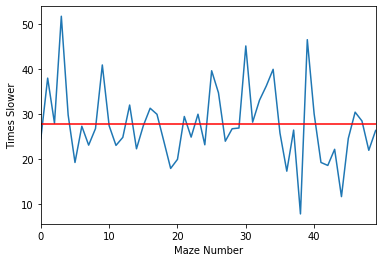

In [20]:
fig, ax = plt.subplots()
ax = df.iloc[:, 2].plot.line()
plt.axhline(y=np.mean(df.iloc[:, 2]), color='r', linestyle='-')
ax.set(xlabel= 'Maze Number',
       ylabel='Times Slower');

Figure 3.1 (above) is the visualization of column 3 (`timesSlower`) of Table 3.1, and shows how many times slower `forward_a2` is with respect to `forward_a`. Since the graph is always positive for all fifty runs, breaking ties by selecting for larger g-values is always faster than selecting for smaller g-values in our test mazes. On average, selecting for a smaller g-value is 27.74 times slower than selecting for a greater g-value, as represented by the horizontal red line. A brief explanation is that by opting for states with a larger g-value, we are selecting for states that are farther away from the spawn state and assumedly closer to the goal state. Let's delve into this explanation with the following example.

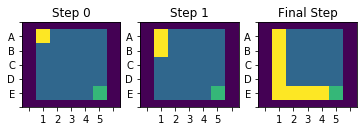

In [107]:
grid = [[1 for j in range(7)] for i in range(7)]

for i in range(7):
    grid[0][i] = 0
    grid[6][i] = 0
    grid[i][0] = 0
    grid[i][6] = 0
grid[1][1] = 3
grid[5][5] = 2

grid2 = deepcopy(grid)
grid2[2][1] = 3

grid3 = deepcopy(grid)
for i in range(4):
    grid3[i+2][1] = 3
    grid3[5][i+1] = 3

grid_np = np.asarray(grid)
grid_np2 = np.asarray(grid2)
grid_np3 = np.asarray(grid3)


fig, ax = plt.subplots(1, 3)
ax[0].imshow(grid_np)
ax[1].imshow(grid_np2)
ax[2].imshow(grid_np3)

ax[0].set(title='Step 0',
          xticks=np.arange(0, 7, step=1),
          xticklabels=['', '1', '2', '3', '4', '5', ''],
          yticks=np.arange(0, 7, step=1),
          yticklabels=['', 'A', 'B', 'C', 'D', 'E', ''])

ax[1].set(title='Step 1',
          xticks=np.arange(0, 7, step=1),
          xticklabels=['', '1', '2', '3', '4', '5', ''],
          yticks=np.arange(0, 7, step=1),
          yticklabels=['', 'A', 'B', 'C', 'D', 'E', ''])

ax[2].set(title='Final Step',
          xticks=np.arange(0, 7, step=1),
          xticklabels=['', '1', '2', '3', '4', '5', ''],
          yticks=np.arange(0, 7, step=1),
          yticklabels=['', 'A', 'B', 'C', 'D', 'E', '']);

Figure 3.2 (above) shows how the Forward A\* algorithm uses a larger g-value to solve tie breaks and computes a path from the agent to the target state. During our analysis, we will not reference our integer value ($c\times f(s) - g(s)$) implementation, but rather use the standard $f(s) = g(s) + h(s)$ metric for clarity. Step 0 is the initial maze where the spawn state is the yellow block at A1 and the goal state is the green block at E5. 

Step 0: At A1, the only two states our algorithm can choose from our open list to expand are B1 and A2 based on their $f(s)$ value. $f(s) = g(s) + h(s)$, where $g(s)$ is the cost to travel from the spawn state and $h(s)$ is the distance to the goal state by the Manhattan heuristic. B1 and A2 have a $f(s)$ value of 8 since they both have a g-value of 1 being one step away from the A1, and both also have an h-value of 7. Since the g-values are equivalent, the Forward A\* algorithm selects a random state and chooses B1, as seen by the extension of the yellow block, which now represents states expanded. It then removes A1 and adds C1 and B2 to the open list.

Step 1: At B2, the algorithm can now choose from C1, B2, and A2 from the open list to expand. A2 still has a $f(s) = g(s) + h(s) = 1 + 7 = 8$, B2 has a $f(s) = 2 + 6 = 8$, and C1 has a $f(s) = 2 + 6 = 8$. Since all three states have the same f-value, Forward A\* now selects the largest g-value. In this case, it is a tie between B2 and C1, and one of the two is randomly selected. Regardless of the state we choose between B2 and C1, by selecting a larger g-value, Forward A\* will always choose a state farther away from the spawn state.

Final Step: Fast forward a few steps to when our algorithm reaches the target state, and we see the benefit of breaking tie-breakers with selecting a larger g-value. Keep in mind, our algorithm doesn't hug an outer wall or move in an L shape, we choose B2, C2, D2, and E2 for the tie breakers in our representation to have a more intuitive visualization of the benefits of choosing a larger g-value. Now let's compare this to what happens when we use a Forward A\* that selects the smaller g-value to break states with the same f-value in Figure 3.3 (below).

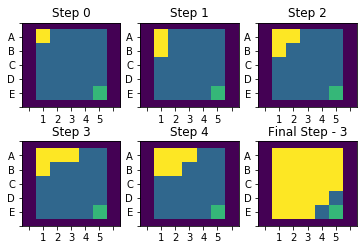

In [115]:
grid = [[1 for j in range(7)] for i in range(7)]

for i in range(7):
    grid[0][i] = 0
    grid[6][i] = 0
    grid[i][0] = 0
    grid[i][6] = 0
grid[1][1] = 3
grid[5][5] = 2

grid2 = deepcopy(grid)
grid2[2][1] = 3

grid3 = deepcopy(grid2)
grid3[1][2] = 3

grid4 = deepcopy(grid3)
grid4[1][3] = 3

grid5 = deepcopy(grid4)
grid5[2][2] = 3

grid6 = [[3 for j in range(7)] for i in range(7)]
for i in range(7):
    grid6[0][i] = 0
    grid6[6][i] = 0
    grid6[i][0] = 0
    grid6[i][6] = 0
grid6[5][4] = 1
grid6[4][5] = 1
grid6[5][5] = 2


grid_np = np.asarray(grid)
grid_np2 = np.asarray(grid2)
grid_np3 = np.asarray(grid3)
grid_np4 = np.asarray(grid4)
grid_np5 = np.asarray(grid5)
grid_np6 = np.asarray(grid6)


fig, ax = plt.subplots(2, 3)
ax[0][0].imshow(grid_np)
ax[0][1].imshow(grid_np2)
ax[0][2].imshow(grid_np3)
ax[1][0].imshow(grid_np4)
ax[1][1].imshow(grid_np5)
ax[1][2].imshow(grid_np6)

ax[0][0].set(title='Step 0',
          xticks=np.arange(0, 7, step=1),
          xticklabels=['', '1', '2', '3', '4', '5', ''],
          yticks=np.arange(0, 7, step=1),
          yticklabels=['', 'A', 'B', 'C', 'D', 'E', ''])

ax[0][1].set(title='Step 1',
          xticks=np.arange(0, 7, step=1),
          xticklabels=['', '1', '2', '3', '4', '5', ''],
          yticks=np.arange(0, 7, step=1),
          yticklabels=['', 'A', 'B', 'C', 'D', 'E', ''])

ax[0][2].set(title='Step 2',
          xticks=np.arange(0, 7, step=1),
          xticklabels=['', '1', '2', '3', '4', '5', ''],
          yticks=np.arange(0, 7, step=1),
          yticklabels=['', 'A', 'B', 'C', 'D', 'E', '']);

ax[1][0].set(title='Step 3',
          xticks=np.arange(0, 7, step=1),
          xticklabels=['', '1', '2', '3', '4', '5', ''],
          yticks=np.arange(0, 7, step=1),
          yticklabels=['', 'A', 'B', 'C', 'D', 'E', '']);

ax[1][1].set(title='Step 4',
          xticks=np.arange(0, 7, step=1),
          xticklabels=['', '1', '2', '3', '4', '5', ''],
          yticks=np.arange(0, 7, step=1),
          yticklabels=['', 'A', 'B', 'C', 'D', 'E', ''])

ax[1][2].set(title='Final Step - 3',
          xticks=np.arange(0, 7, step=1),
          xticklabels=['', '1', '2', '3', '4', '5', ''],
          yticks=np.arange(0, 7, step=1),
          yticklabels=['', 'A', 'B', 'C', 'D', 'E', '']);

Figure 3.3 (above) shows how the Forward A\* algorithm uses a smaller g-value to solve tie breaks and computes a path from the agent to the target state. Again, step 0 is the initial maze where the spawn state is the yellow block at A1 and the goal state is the green block at E5. 

Step 0: The same situation that occurs in Forward A\* occurs again in that the only two states that can be expanded are B1 and A2, where both have a value of 8. Since the g-values are equivalent, the Forward A\* algorithm selects a random state and chooses B1, as seen by the extension of the yellow block, which now represents states expanded. It then adds C1 and B2 to the open list.

Step 1: At B2, the algorithm can now choose from C1, B2, and A2 from the open list to expand. Every cell in the grid, other than the spawn state and target state, actually has the same f-value of 8 and we will conduct our future analysis with this understanding in mind. Since all three states have the same f-value, Forward A\* now selects the smallest g-value. In this case, Forward A\* chooses A2 since it has the smallest g-value of the three, and removes B2 while adding A3 to the open list.

Step 2: At A2, the algorithm now can choose from C1, B2, and A3 from the open list to expand and all actually have the same g-values. A3 is randomly selected between the three, and removes A2 while adding A4 and B3 to the open list.

Step 3: At A3, the algorithm can now choose between A4, C1, B2, and B3 from the open list. A4 and B3 have g-values of 3, while C1 and B2 have smaller g-values of 2. Thus, B2 is randomly selected between C1 and B2, removed from the openlist, and C2 is added to the open list.

Step 4: At B2, the algorithm can now choose between A4, B3, C1, and C2 from the open list. A4, B3, and C2 all have g-values of 3 while C1 has a smaller g-value of 2. Thus, C1 is selected and we can now start to see a pattern occurring. Since Forward A\* is always selecting the smallest g-value on the open list, the algorithm will expand unnecessary states that are farther away from the target state.

Final Step - 3: Fast forward a few steps to when our algorithm almost reaches the target state, and we see the downside of breaking tie-breakers with selecting a smaller g-value. Since the algorithm always breaks states with the same f-values by choosing a state closer to the spawn state, we can intuitively realize that the algorithm will choose to expand "horizontally" with respect to the target state instead of propagating towards the target state in a directed manner. This is why the average runtime for Forward A\* that solves tie breakers by selecting smaller g-values is almost 28 times slower than if it selected for larger g-values.

# Forward vs Backward A*

Implementation details: Note that both our Forward and Backward A\* implementations break ties between states with the same f-value by selecting the greater g-value. We run both algorithms on all 50 mazes and collect data on the runtimes. The runtime for an algorithm is equivalent to the total expanded states of that algorithm. Again, we choose to measure total expanded states rather than the total number of uniquely expanded states since we feel that this metric would be more telling of runtime. If our A* algorithm searches over the same expanded states each iteration, we would like our runtime measurement to reflect that. Keep in mind that our spawn and target states are always at [5,5] and [95,95] respectively for a more consistent comparison. Table 4.1 (below) shows the runtime for both algorithms, and how much slower Backward A\* is compared to Forward A\* for the first ten mazes. 

In [10]:
pd = nb_setup.setup_pandas(escape_latex = True)
reach_target_f = []
expanded_states_f = []
reach_target_b = []
expanded_states_b = []

for i in range(50):
    maze = Maze(101, 101, i)
    reach_target, expanded_states, final_path = forward_a(maze)
    reach_target_f.append(reach_target)
    expanded_states_f.append(expanded_states)
    
    maze = Maze(101, 101, i)
    reach_target, expanded_states, final_path = backward_a(maze)
    reach_target_b.append(reach_target)
    expanded_states_b.append(expanded_states)
    
d_forward = {'reach_target':reach_target_f,'expanded_states':expanded_states_f}
df_forward = pd.DataFrame(d_forward)
df_forward.rename(columns={'expanded_states': 'forward_runtime'}, inplace=True)

d_backward = {'reach_target':reach_target_b,'expanded_states':expanded_states_b}
df_backward = pd.DataFrame(d_backward)
df_backward.rename(columns={'expanded_states': 'backward_runtime'}, inplace=True)

df = pd.concat([df_forward, df_backward], axis=1, sort=False)
df = (df.assign(forward_astar_faster = lambda df: df.iloc[:,1] < df.iloc[:,3])
        .assign(timesSlower = lambda df: (df.iloc[:,3] - df.iloc[:,1]) / df.iloc[:,1])
        .rename(columns={'forward_runtime': 'forwardRuntime', 'backward_runtime': 'backwardRuntime'})
        .iloc[:, [1, 3, 5]])
df.head(10)

,forwardRuntime,backwardRuntime,timesSlower
0,9270,110189,10.886624
1,8547,103198,11.074178
2,8924,108192,11.123711
3,5229,84779,15.213234
4,9669,142384,13.725825
5,8153,88336,9.834785
6,6398,125408,18.601125
7,7421,115264,14.532139
8,7467,87396,10.704299
9,6180,58531,8.471036


In [11]:
print('timesSlower', np.mean(df.iloc[:, 2]))
print('% of 50 Forward A* faster', np.mean(df.iloc[:, 2]) / 50)

timesSlower 11.995538147638316
% of 50 Forward A* faster 0.2399107629527663


Figure 4.1 (below) is the visualization of column 3 (`timesSlower`) of Table 4.1, and shows how many times slower Backward A\* is with respect to Forward A\*. On average, Backward A\* is about 12 times slower than Forward A\*, as represented by the horizontal red line. Since the graph is always positive for all fifty runs, Backward A\* is always slower compared to Forward A\* without exception for our test cases. Taking a closer look, we see that there are many spikes in Backward A\*'s runtime throughout the graph. The reason for these runtime differences seen at these peaks between the two algorithms can be discerned by observing where the algorithm searches begin.

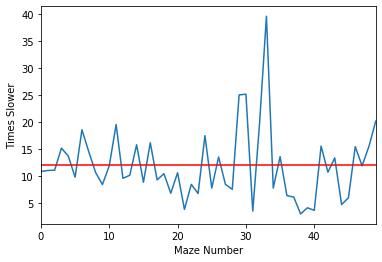

In [12]:
fig, ax = plt.subplots()
ax = df.iloc[:, 2].plot.line()
plt.axhline(y=np.mean(df.iloc[:, 2]), color='r', linestyle='-')
ax.set(xlabel= 'Maze Number',
       ylabel='Times Slower');

One main reason why Backward A\* is slower than Forward A\* is the result of the opposite starting points of the two search algorithms. Forward A\*, as the name suggests, begins at the state where the agent resides and searches in the direction of the target state. The greatest amount of information regarding blocked states comes from the states directly adjacent to the agent (not including the states the agent already passed through). Thus, Forward A\* can avoid calculating paths to the target state that are blocked off since the start of each algorithm always considers the agent's immediate surroundings. On the other hand, Backward A\* begins at the target state and searches in the direction of the agent. The area around the target state is completely unseen since the agent is assumedly not nearby and cannot see whether any of the neighboring states around the target state are blocked. Thus, Backward A\* cannot account for any blocked states until it either trespasses already seen states or gets directly next to the agent. And at that point, it is already too late to bring out a search algorithm's full potential. Take a look at the following example, Figure 4.2 (below), that exemplifies our explanation of why Backward A\* is much slower than Forward A\*. 

In [186]:
""" Backward A* Explanation algorithm
This Backward A* has been adapted to show a specific example on a 50 x 50 maze grid.
""" 
def backward_a_exp(maze):
    
    # Part 1: State class
    class State:

        def __init__(self, row, column, maze):
            self.coord = [row, column]
            self.maze = maze
            self.g = None
            self.f = None
            self.pointer = None
            self.search = 0
            
            # What the agent sees at each iteration of A*
            self.agent_map = 1
        
        # h-value needs to update as the maze target moves
        @property
        def h(self):
            return (abs(self.coord[0]-self.maze.target[0])
                    + abs(self.coord[1]-self.maze.target[1]))
        
        # Single value used to compare state priorities
        @property
        def priority(self):
            return self.maze.g_max*self.f - self.g
        
        def init_f(self):
            self.f = self.g + self.h

        # For binary heap open list to compare states
        def __lt__(self, other):
            if self.priority == other.priority:
                return np.random.uniform() > .5
            else:
                return self.priority < other.priority

    # Part 2: compute_path method
    def compute_path():
        path_len = 0
        maze.g_max = 0
        
        # Loop until target state g-value <= least f-value of open list
        while state_target.g > open_list[0].f:
            path_len += 1

            # Removing least f-value state from open list and add to closed list
            if path_len == 1:
                closed_list.next = Node(hp.heappop(open_list))
            else:            
                node_insert = Node(hp.heappop(open_list))
                closed_list.next.prev = node_insert
                node_insert.next = closed_list.next
                closed_list.next = node_insert
            if counter == 3:
                expanded_states1.append(closed_list.next.data))
            
            # Counter for expanded states
            total_expanded_states_count.append(1)

            # For each child of the expanded state, do the following
            for child, direction in zip(range(4), [[-1, 0], [1, 0], [0, 1], [0, -1]]): 
                row = closed_list.next.data.coord[0] + direction[0]
                column = closed_list.next.data.coord[1] + direction[1]

                # Check that the successor state is not outside the maze
                if row < 0 or row >= maze.rows or column < 0 or column >= maze.columns:
                    continue
                # Skip successor state if it is a blocked state
                elif total_states[row][column].agent_map == 0:
                    continue   
                # Select child as successor state
                else:
                    state_succ = total_states[row][column]
                 
                # Check if successor state is already part of this current compute_path iteration
                if state_succ.search < counter:
                    state_succ.g = float('inf')
                    state_succ.search = counter
                
                # Sets the parent pointer and adjusts g-value for successor state
                if state_succ.g > closed_list.next.data.g + 1:
                    state_succ.g = closed_list.next.data.g + 1
                    state_succ.pointer = closed_list.next.data
                    
                    # Find the highest max g-value for state priorities
                    if maze.g_max < state_succ.g:
                        maze.g_max = state_succ.g
                        
                    # Checks and removes if sucessor state is already in open list
                    for state, i in zip(open_list, range(len(open_list))):
                        if state_succ.coord == state.coord:
                            open_list[i] = open_list[0]
                            hp.heappop(open_list)
                            hp.heapify(open_list)
                        
                    # Initialize f value for successor state
                    state_succ.init_f()
                    
                    # Add successor state to open list and reorder accordingly
                    hp.heappush(open_list, state_succ)
                    hp.heapify(open_list)
            
            # Break if open list is empty
            if len(open_list) == 0:
                break

    # Part 3: Main method
    
    # Switching maze target and maze spawn since this is backwards algorithm
    temp_coord = maze.target
    maze.target = maze.spawn
    maze.spawn = temp_coord
    
    success = True # Whether our agent reaches target
    counter = 0 # How many steps our agent takes
    
    # All the possible states are first assumed as unblocked by our agent
    total_states = ([[State(i, j, maze) for j in range(maze.columns)]
                     for i in range(maze.rows)])
    total_expanded_states_count = []
    
    # Initiate spawn and target states in our total states
    state_spawn = total_states[maze.spawn[0]][maze.spawn[1]]
    state_target = total_states[maze.target[0]][maze.target[1]]
    state_spawn.agent_map = 2
    state_target.agent_map = 3
    
    # Initialize neighboring states of original spawn (now state target)
    for child, direction in zip(range(4), [[-1, 0], [1, 0], [0, 1], [0, -1]]): 
        row = state_target.coord[0] + direction[0]
        column = state_target.coord[1] + direction[1]

        # Check that state is not outside the maze
        if row < 0 or row >= maze.rows or column < 0 or column >= maze.columns:
            continue
        else:
            # agent_map (what the agent sees) is updated
            total_states[row][column].agent_map = maze.grid[row][column]
            
    # For visualization of full agent path
    full_path = []
    full_path.append(state_target.coord)
    
    expanded_states1 = []
    
    # Loop while spawn state doesn't move to target state
    while state_spawn.coord != state_target.coord:
        
        # As spawn state moves each iteration (counter), add to final_path
        counter += 1
        
        # Initiate spawn, target, open/closed lists
        state_spawn.g = 0
        state_spawn.init_f()
        state_spawn.search = counter
        state_target.g = float('inf')
        state_target.search = counter
        open_list = []
        closed_list = Linked_list()

        hp.heappush(open_list, state_spawn)
        compute_path()
        
        # When agent doesn't reach the target
        if len(open_list) == 0:
            success = False
            break
        
        # Using pointers to get back to spawn state
        state_curr = open_list[0]
        path = []
        path.append(state_curr.coord)
        
        path2 = []
        state_curr2 = closed_list.next
        path2.append(state_curr2.data)
        
        while state_curr2.next != None:
            state_curr2 = state_curr2.next
            path2.append(state_curr2.data)
        
        
        while state_curr.coord != state_spawn.coord:
            state_curr = state_curr.pointer
            path.append(state_curr.coord)
        
        if counter == 3:
            break
        
        # Move agent, set spawn state to new state, and rerun
        for i, coord in zip(range(len(path)-1), path):
            
            # Check that the next state isn't blocked
            if maze.grid[path[i+1][0]][path[i+1][1]] != 0:
                
                # Move agent into the new state and add to full path
                state_target = total_states[path[i+1][0]][path[i+1][1]]
                maze.target = path[i+1]
                full_path.append(state_target.coord)
                
                # For all neighboring states do the following
                for child, direction in zip(range(4), [[-1, 0], [1, 0], [0, 1], [0, -1]]): 
                    row = state_target.coord[0] + direction[0]
                    column = state_target.coord[1] + direction[1]

                    # Check that neighboring state is not outside the maze
                    if row < 0 or row >= maze.rows or column < 0 or column >= maze.columns:
                        continue
                    else:
                        total_states[row][column].agent_map = maze.grid[row][column]

            else:
                # Update blocked state on agent_map
                total_states[path[i+1][0]][path[i+1][1]].agent_map = 0
                break
                
    # Resetting maze target and spawn for print purposes
    temp_coord = maze.target
    maze.target = maze.spawn
    maze.spawn = temp_coord

    # Printing results and returning
    if success == True:
        reach_target = "Yes"
        #print("Your agent reached the target!")
    else:
        reach_target = "No"
        #print("Your agent couldn't reach the target...")
    expanded_states = len(total_expanded_states_count)
    #print('Total expanded states:', expanded_states)
    
    return reach_target, expanded_states, full_path, expanded_states1, total_states

In [21]:
# Custom print method to show the total expanded states within an iteration of A* compute_path()
def print_expanded_states(expanded_states, total_states):
    agent_map = [[1 for j in range(len(total_states[0]))] for i in range(len(total_states))]
    
    for i in range(len(total_states)):
        for j in range(len(total_states[0])):
            if total_states[i][j].agent_map == 1:
                agent_map[i][j] = 2
            else:
                agent_map[i][j] = 0
    
    agent_map2 = deepcopy(agent_map)
    
    color = 7.33
    last_state = expanded_states[0]
    for state in expanded_states:
        if state.priority > last_state.priority:
            color += 0.1
        agent_map[state.coord[0]][state.coord[1]] = color
        last_state = state
    
    agent_map[28][31] = 6.7
    agent_map[43][20] = 5.33
    agent_map[20][32] = 10
    
    for state in expanded_states:
        if state.coord == [35, 30]:
            agent_map2[35][30] = 8.5
            break
        agent_map2[state.coord[0]][state.coord[1]] = 7.33
    agent_map2[28][31] = 6.7
    agent_map2[43][20] = 5.33
    agent_map2[20][32] = 10
    
    grid_path_np = np.asarray(agent_map)
    grid_path_np2 = np.asarray(agent_map2)

    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(grid_path_np2, cmap='jet')
    ax[1].imshow(grid_path_np, cmap='jet')
    plt.tight_layout();
# Color map
# for i in range(4):
#     for j in range(4):
#         arry[i][j] = fill[4*i + j]
# plt.imshow(arry, cmap = 'jet')

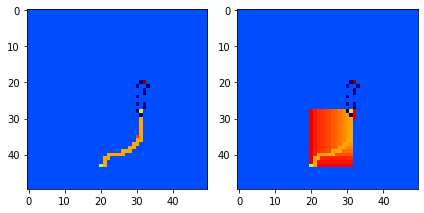

In [188]:
# Uncomment Maze object (above) spawn/target code so that 
# they are random and not set at [5,5] and [95, 95]
maze = Maze(50, 50, 1)
a, b, c, d, e = backward_a_exp(maze)
print_expanded_states(d, e)

Figure 4.2 (above) shows what our agent sees at a bottleneck iteration (#3) of the Backward A\* algorithm that ends up expanding way too many states before finding a successful path. First consider the left graph: the target state [43, 20] is green and our current agent location [28, 31] is yellow (original spawn location [20, 32] is dark brown). The light orange path is the current Backward A\* search that begins at the target state and propagates towards the agent location. However, right before it reaches the agent location [28, 31], it meets a blocked state at [29,31]. This blocking phenomenon would never occur for Forward A\* towards the end of a search, because all the blocked states are usually at the origin of the search, where the agent is located. What ends up happening in this case is that the surrounding states around [29,32] all have a higher f-value than some previous f-value that is "farther away" than the end of the search. In this case, our Backward A\* ends up doubling back and selecting the state at [35, 30], as shown in the darker orange box in the left graph. Fast forward the current search until completion, shown in the right graph, and we can see how Backward A\* inefficiently expands all these other states with lower f-values before finally finding that detour to the agent location [28, 31].

# Heuristics in the Adaptive A* (Part 1)

**The project argues that "the Manhattan distances are consistent in gridworlds in which the agent can only move in the four main compass directions." Prove that this is indeed the case.**

Our project uses Manhattan distances as heuristics or h-values. Manhattan distance is the sum of the horizontal and vertical distances between points (cells in our case) in a grid. Consider ($x,y$) and ($x_1$,$y_1$) cells in a grid. Then Manhattan distance m is
$$m = |x-x_1| + |y-y_1|$$
To prove any heuristic h is consistent, we have to prove the following property:
$$h(n) \le c(n,a,n_1) + h(n_1)$$
$h(n)$ is the h-value of $n$.                       
$c(n,a,n_1)$ is the cost function to reach $n_1$ from $n$.                 
$h(n_1)$ is the h-value of $n_1$. 

In our Manhattan distances case, we prove this property and heuristic consistency through proof by mathematical induction.
In the grid world, the action cost to move between any two neighbouring cells is the same, which is 1. If ($n,n_1$), ($n_1,n_2$) and ($n_2,n_3$) are pairs of neighbouring cells, then
$$c(n,a,n_1)=c(n_1,a,n_2)=c(n_2,a,n_3)=1$$
Now apply the given property to some cells $n_1$ and $n$ as its neighbour.
$$h(n) \le c(n,a,n_1) + h(n_1)$$
Since we know that the action cost to move between any two neighbouring cells is 1,
$$h(n) \le 1 + h(n_1)$$
Now add $1$ to both sides of the inequality:
$$h(n) +1 \le 1 + h(n_1) +1$$
Consider that there is a next cell $n_2$ which is a neighbour of $n_1$.
$$h(n_1) \le c(n_1,a,n_2) + h(n_2)$$
Given that consistency property holds for the cell $n_2$, by induction, this also holds for all values of n.   
Thus, Manhattan distances are consistent in gridworlds in which the agent can move only in the four main compass directions.


**Furthermore, it is argued that “The h-values $h_{new}$(s) ... are not only admissible but also consistent.” Prove that Adaptive A* leaves initially consistent h-values consistent even if action costs can increase.**

Adaptive A* search uses previous A* search experience to update the h-values of the cells or states that were expanded in the previous A* search. $g(s)$ is the smallest distance from start state to current state and $g(s_{goal})$ is the distance from the start state to goal state. Here we update the h-values for expanded cells with $g(s_{goal})$ - $g(s)$ as $h_{new}$-values. With the current knowledge of the gridworld, $g(s_{goal})$-$g(s)$ is the smallest distance from cell $s$ to goal state. In the future, Adaptive A* is going to expand more unblocked cells and the cost will increase. So the new h-values of Adaptive A* are consistent and have the smallest cost from the present state to goal state.
$$h_{new}(s)=g(s_{goal})-g(s)$$
To prove that $h_{new}$-values are consistent, we assume that $h_{new}$ is consistent. From the definition of heuristic consistency:
$$h_{new}(s) \le c(s,a,s_{next}) + h_{new}(s_{next})$$
Using the above two equations we get,
$$g(goal)-g(s) \le c(s,a,s_{next}) + g(goal) - g(s_{next})$$
After solving the above equation we get,
$$g(s_{next})-g(s) \le c(s,a,s_{next})$$
From the A* search algorithm we know that $g(s)$ is the smallest distance from the start state to current state $s$, and $g(s_next)$ is the smallest distance from the start state to state $s_next$. We know that the smallest distance between $s$ state and $s_{next}$ state is the action cost between $s$ state and $s_{next}$ state. By representing this in equation form we get,
$$g(s_{next})-g(s) = c(s,a,s_{next})$$
From this, we proved that for every $s$,$a$,$s_{next}$ value,
$$g(s_{next})-g(s) \le c(s,a,s_{next})$$
This proves that, Adaptive A* leaves initially consistent h-values consistent even if the action costs increase.

# Heuristics in the Adaptive A* (Part 2)

Implementation Details: Our implementation of Forward and Adaptive A\* solves ties between states with the same f-value by selecting the state with the greater g-value. We again run both algorithms on all 50 mazes and collect data on the runtimes. The runtime for an algorithm is equivalent to the total expanded states of that algorithm. Again, we choose to measure total expanded states rather than the total number of uniquely expanded states since we feel this metric would be more telling of runtime. If our A* algorithm searches over the same expanded state each iteration, we would like our runtime measurement to reflect that. Keep in mind that our spawn and target states are always at [5,5] and [95,95] respectively for a more consistent comparison. Table 6.1 below shows the runtime for both algorithms, whether Adaptive A\* was faster than Forward A\*, and how many times slower Forward A\* is compared to Adaptive A\* for the first ten mazes.

In [9]:
pd = nb_setup.setup_pandas(escape_latex = True)
reach_target_f = []
expanded_states_f = []
reach_target_a = []
expanded_states_a = []

for i in range(50):
    maze = Maze(101, 101, i)
    reach_target, expanded_states, final_path = forward_a(maze)
    reach_target_f.append(reach_target)
    expanded_states_f.append(expanded_states)
    
    maze = Maze(101, 101, i)
    reach_target, expanded_states, final_path = adaptive_a(maze)
    reach_target_a.append(reach_target)
    expanded_states_a.append(expanded_states)
    
d_forward = {'reach_target':reach_target_f,'expanded_states':expanded_states_f}
df_forward = pd.DataFrame(d_forward)
df_forward.rename(columns={'expanded_states': 'forwardRuntime'}, inplace=True)

d_adaptive = {'reach_target':reach_target_a,'expanded_states':expanded_states_a}
df_adaptive = pd.DataFrame(d_adaptive)
df_adaptive.rename(columns={'expanded_states': 'adaptiveRuntime'}, inplace=True)

df = pd.concat([df_forward, df_adaptive], axis=1, sort=False)
df = (df.assign(adaptive_faster = lambda df: df.iloc[:,1] > df.iloc[:,3])
        .assign(timesSlower = lambda df: (df.iloc[:,1] - df.iloc[:,3]) / df.iloc[:,3])
        .iloc[:, [1, 3, 4, 5]])
df.head(10)

,forwardRuntime,adaptiveRuntime,adaptive_faster,timesSlower
0,9270,8166,True,0.135195
1,8547,13929,False,-0.386388
2,8924,9466,False,-0.057258
3,5229,8375,False,-0.375642
4,9669,9616,True,0.005512
5,8153,5716,True,0.426347
6,6398,5781,True,0.106729
7,7421,7695,False,-0.035608
8,7467,7300,True,0.022877
9,6180,5446,True,0.134778


In [10]:
print('timesSlower', np.mean(df.iloc[:, 3]))
print('% of 50 Adaptive A* faster', np.mean(df.iloc[:, 3]) / 50)

0.013314646939733492

Figure 6.1 (below) is the visualization of column 4 (`timesSlower`) of Table 6.1, and shows how many times slower Forward A\* is with respect to Adaptive A\*. On average, the runtime for Adaptive A\* is about 1.33% faster with respect to Forward A\* as represented by the horizontal red line. This is an incredibly small percent improvement for our limited sample size, such that we can claim that Adaptive A\*'s runtime improvement is negligible in comparison to Forward A\* in our test mazes. We see that the graph is not always positive for all fifty runs, indicating that in many cases Adaptive A\* is actually slower than Forward A\*. In fact, for our 50 test mazes, Adaptive A\* is only faster 42% of the time. Such a negligible average runtime difference, represented by the red line, almost contradicts our expectation that Adaptive A\* is faster than Forward A\*.

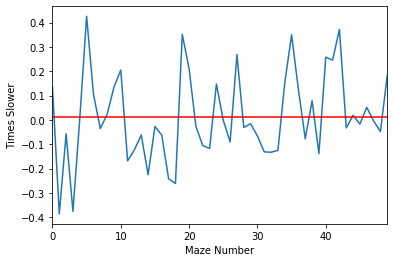

In [15]:
fig, ax = plt.subplots()
ax = df.iloc[:, 3].plot.line()
plt.axhline(y=np.mean(df.iloc[:, 3]), color='r', linestyle='-')
ax.set(xlabel= 'Maze Number',
       ylabel='Times Slower');

The main reason for such a lack of difference between the algorithms is due to the construction of our maze world. We generate our maze world where each block has a 30% of being blocked. As you can see from Figure 6.2 (below), this style of maze creation leads to a very random design that isn't very maze-like with long corridors. Instead, it's more like a sea of random blocks where this randomness of blocked states is the crux to why the Adaptive A\* algorithm fails to perform better than Forward A\*.

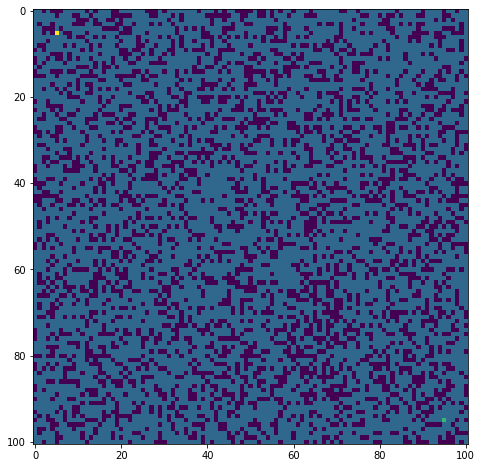

In [9]:
maze = Maze(101, 101, 1)
print_grid(maze)

A typical maze, depending on the algorithm that builds it usually has some winding paths or corridors. To put it simply, there are stretches of cells that are in a straight line going vertically or horizontally. Consider the following situation where our agent computes a path down one of these corridors and moves down this path until hitting a blocked cell. Adaptive A\* shines in that the path the agent just took is less likely to be chosen again in the next few iterations since all the h-values are updated to account for the cost of moving through these states. As a result, our next search is more likely to not expand the same states and waste time traversing the same path the agent just took, opting for a new path in the direction of the target state. However, in our maze world where these straight line corridors are less likely to appear, Adaptive A\*'s effectiveness is greatly reduced. The agent cannot travel many steps until a random block appears and stops its progress, so the algorithm ends up re-exploring many of the same states either way. This causes Adaptive A\* to have a similar runtime in comparison to Forward A\*.

# Statistical Significance

**Performance differences between two search algorithms can be systematic in nature or only due to sampling noise (= bias exhibited by the selected test cases since the number of test cases is always limited). One can use statistical hypothesis tests to determine whether they are systematic in nature. Describe for one of the experimental questions above exactly how a statistical hypothesis test could be performed.**

One can use statistical hypothesis tests to determine performance between two search algorithms to be systematic in nature or only due to sampling noise. Hypothesis testing is a type of statistical inference that can be used in many ways to evaluate whether one's sample results is representative on a population level. There are different types of hypothesis tests like z-test, t-test etc. One chooses the hypothesis testing depending on the sample size, known or unknown population parameters and various other factors. 

Let us validate whether Repeated Forward A* and Repeated Backward A* have a difference in mean runtime. In our case, the two sample sizes are 50 since we collected sets of runtime results from Repeated Forward A* and Repeated Backward A* search execution on the same set of 50 gridworlds. We decide to use a paired t-test on an $alpha$ = 5% level to compare the Repeated Forward A* and Repeated Backward A* search algorithms because both algorithms are running on the same set of gridworlds.

Consider $N$ as the sample size of both Repeated Forward A* and Repeated Backward A* search algorithms. Let the difference between runtimes of Repeated Forward A* and Repeated Backward A* be $\delta$.
$$\delta = F-B$$
$F$ is the runtime of Repeated Forward A* on a single gridworld.  
$B$ is the runtime of Repeated Backward A* on a single gridworld.  

After finding all the $\delta$ values of 50 gridworlds, we calculate the mean value and standard deviation of the $\delta$ values:
$x_{\delta}$ is the mean value of all differences.   
$S_{\delta}$ is the standard deviation of all differences.   

Now we formulate the null and alternative hypothesis. The null hypothesis assumes that the mean difference in runtimes between the two search strategies is zero, and the alternative hypothesis suggests that the difference in means is not equal to zero.      
$H_{0}$:$\mu_{\delta}$ = 0.     
$H_{1}$:$\mu_{\delta}$ $\neq$ 0.     

Now we can validate this null hypothesis with by calculating the test statistic for our hypothesis test, represented by $t_{\delta}$.
$$t_{\delta}=\frac{x_{\delta} - \mu_{\delta}}{\frac{S_{\delta}}{\sqrt{N_{\delta}}}}$$
$N_{\delta}$ is the number of pairs i.e number of gridworlds. 

After calculating the test statistic, we calculate the $p$-value, which is the chance that our results are insignificant by chance. The $p$-value can be obtained through our test statistic with $N_{\delta}- 1$ degrees of freedom.
The lower the $p$-value, the lower the probability that our results were caused by chance and we can reject the null hypothesis. Since our hypothesis test is evaluated on a 5% level, our $p$-value needs to be less than 5% for us to conclude that there is enough data to reject the null hypothesis and say the alternative hypothesis is true. If our alternative hypothesis is true, we can say that the difference in mean runtimes between our algorithms is not zero whereas we know that Backward A\* is slower than Forward A\*. Note that the possibility that the null hypothesis is true can never be ruled out.

# Proof of Implementation

Forward A*
Reached target: Yes
Runtime: 9270


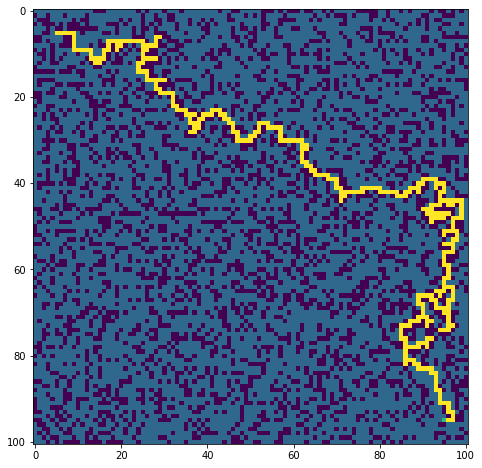

In [17]:
# Presentation for TA Code

maze = Maze(101, 101, 0)
reached_target, expanded_states, full_path = forward_a(maze)
print('Forward A*')
print('Reached target:', reached_target)
print('Runtime:', expanded_states)
print_agent_fpath(maze, full_path)

Backward A*
Reached target: Yes
Runtime: 110189


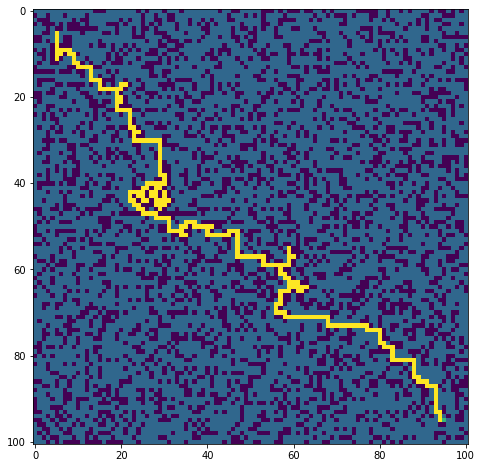

In [18]:
maze = Maze(101, 101, 0)
reached_target, expanded_states, full_path = backward_a(maze)
print('Backward A*')
print('Reached target:', reached_target)
print('Runtime:', expanded_states)
print_agent_fpath(maze, full_path)

Adaptive A*
Reached target: Yes
Runtime: 8166


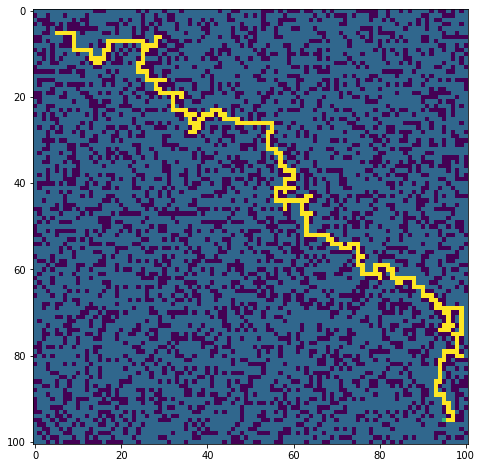

In [19]:
maze = Maze(101, 101, 0)
reached_target, expanded_states, full_path = adaptive_a(maze)
print('Adaptive A*')
print('Reached target:', reached_target)
print('Runtime:', expanded_states)
print_agent_fpath(maze, full_path)

In [15]:
"""
Now let us evaluate the algorithm more specifically on an interation level.
We will use a 10 x 10 maze to make it easier, which require us to adjust our maze
object so that our spawns and target states are random. We slightly tweak our 
print_agent_map method as well. We adjust our three A* algorithms so that they 
can pause on a given iteration.
"""

# Maze class for our 101 x 101 sized grid worlds
class Maze:
    
    def __init__(self, rows, columns, seed):
        self.rows = rows
        self.columns = columns
        self.grid, self.spawn, self.target = self.create_grid(seed)
        self.g_max = 0
    
    def create_grid(self, seed):
        # Initialize maze grid
        grid = [[1 for j in range(self.columns)] for i in range(self.rows)]

        # Determine which states (cells) are blocked
        np.random.seed(seed)
        grid_blocked = np.random.uniform(size=(self.rows, self.columns))
        
        for i in range(self.rows):
            for j in range(self.columns):
                if grid_blocked[i][j] <= 0.3:
                    grid[i][j] = 0           
        
        # Marking spawn and target
#         spawn = [5, 5]
#         target = [95, 95]
#         grid[spawn[0]][spawn[1]] = 3
#         grid[target[0]][target[1]] = 2
        
#         # Marking randomly generated spawn and targets
        spawn = [-1, -1]
        target = [-1, -1]
        while (spawn[0] == target[0] and spawn[1] == target[1]):
            spawn[0] = np.random.randint(0, self.rows)
            spawn[1] = np.random.randint(0, self.columns)
            target[0] = np.random.randint(0, self.rows)
            target[1] = np.random.randint(0, self.columns)
        grid[spawn[0]][spawn[1]] = 3
        grid[target[0]][target[1]] = 2

        return grid, spawn, target

In [16]:
# Forward A* algorithm - ADDED LINES TO PAUSE ITERATIONS/PROOF (3 parts)
def forward_a(maze, iteration):
    
    # Part 1: State class
    class State:

        def __init__(self, row, column, maze):
            self.coord = [row, column]
            self.maze = maze
            self.g = None
            self.h = abs(row-maze.target[0]) + abs(column-maze.target[1])
            self.f = None
            self.pointer = None
            self.search = 0
            
            # What the agent sees at each iteration of A*
            self.agent_map = 1
        
        # Single value used to compare state priorities
        @property
        def priority(self):
            return self.maze.g_max*self.f - self.g
        
        def init_f(self):
            self.f = self.g + self.h

        # For binary heap open list to compare states
        def __lt__(self, other):
            if self.priority == other.priority:
                return np.random.uniform() > .5
            else:
                return self.priority < other.priority

    # Part 2: compute_path method
    def compute_path():
        path_len = 0
        maze.g_max = 0
        
        # Loop until target state g-value <= least f-value of open list
        while state_target.g > open_list[0].f:
            path_len += 1
            
            # Removing the state with the least f-value
            if path_len == 1:
                closed_list.next = Node(hp.heappop(open_list))
            else:            
                node_insert = Node(hp.heappop(open_list))
                closed_list.next.prev = node_insert
                node_insert.next = closed_list.next
                closed_list.next = node_insert
            
            # Counter for expanded states
            total_expanded_states_count.append(1)
            
            # For each child of the expanded state, do the following
            for child, direction in zip(range(4), [[-1, 0], [1, 0], [0, 1], [0, -1]]): 
                row = closed_list.next.data.coord[0] + direction[0]
                column = closed_list.next.data.coord[1] + direction[1]
                
                # Check that the successor state is not outside the maze
                if row < 0 or row >= maze.rows or column < 0 or column >= maze.columns:
                    continue
                # Skip successor state if it is a blocked state
                elif total_states[row][column].agent_map == 0:
                    continue
                # Select child as successor state
                else:                                       
                    state_succ = total_states[row][column]
                
                # Check if successor state is already part of this current compute_path iteration
                if state_succ.search < counter:
                    state_succ.g = float('inf')
                    state_succ.search = counter
                
                # Sets the parent pointer and adjusts g-value for successor state
                if state_succ.g > closed_list.next.data.g + 1:
                    state_succ.g = closed_list.next.data.g + 1
                    state_succ.pointer = closed_list.next.data
                    
                    # Find the highest max g-value for state priorities
                    if maze.g_max < state_succ.g:
                        maze.g_max = state_succ.g
                    
                    # Checks and removes if sucessor state is already in open list
                    for state, i in zip(open_list, range(len(open_list))):
                        if state_succ.coord == state.coord:
                            open_list[i] = open_list[0]
                            hp.heappop(open_list)
                            hp.heapify(open_list)
                    
                    # Initialize f value for successor state
                    state_succ.init_f()
                    
                    # Add successor state to open list and reorder accordingly
                    hp.heappush(open_list, state_succ)
                    hp.heapify(open_list)
            
            # Break if open list is empty
            if len(open_list) == 0:
                break

    # Part 3: Main method
    # Maze 22, 40, and 49 are the only mazes which our agent couldn't find the target
    
    success = True # Whether our agent reaches target
    counter = 0 # How many steps our agent takes
    
    # All the possible states are first assumed as unblocked by our agent
    total_states = ([[State(i, j, maze) for j in range(maze.columns)]
                     for i in range(maze.rows)])
    total_expanded_states_count = []
    
    # Initiate spawn and target states in our total states
    state_spawn = total_states[maze.spawn[0]][maze.spawn[1]]
    state_target = total_states[maze.target[0]][maze.target[1]]
    state_spawn.agent_map = 3
    state_target.agent_map = 2
    
    # Initialize neighboring states of original spawn
    for child, direction in zip(range(4), [[-1, 0], [1, 0], [0, 1], [0, -1]]): 
        row = state_spawn.coord[0] + direction[0]
        column = state_spawn.coord[1] + direction[1]

        # Check that state is not outside the maze
        if row < 0 or row >= maze.rows or column < 0 or column >= maze.columns:
            continue
        else:
            # agent_map (what the agent sees) is updated
            total_states[row][column].agent_map = maze.grid[row][column]
            
    # For visualization of full agent path
    full_path = []
    full_path.append(state_spawn.coord)
    
    # Loop while spawn state doesn't move to target state
    while state_spawn.coord != state_target.coord:

        # As spawn state moves each iteration (counter), add to final_path
        counter += 1
      
        # Initiate spawn, target, open/closed lists
        state_spawn.g = 0
        state_spawn.init_f()
        state_spawn.search = counter
        state_target.g = float('inf')
        state_target.search = counter
        open_list = []
        closed_list = Linked_list()
        
        # Push first value into open list and run compute_path
        hp.heappush(open_list, state_spawn)
        compute_path()
        
        # When agent doesn't reach the target
        if len(open_list) == 0:
            success = False
            break    
        
        # Using pointers create current iteration path
        state_curr = open_list[0]
        path = []
        path.append(state_curr.coord)
        while state_curr.coord != state_spawn.coord:
            state_curr = state_curr.pointer
            path.append(state_curr.coord)
        
        # Pause iteration
        if counter == iteration:
            break
       
        # Move agent (state_spawn) until blocked cell
        for i, coord in zip(range(len(path)-1), path):
            
            # Check that the next state isn't blocked
            if maze.grid[path[-i-2][0]][path[-i-2][1]] != 0:
                
                # Move agent into the new state and add to full path
                state_spawn = total_states[path[-i-2][0]][path[-i-2][1]]
                full_path.append(state_spawn.coord)
                
                # For all neighboring states of the do the following
                for child, direction in zip(range(4), [[-1, 0], [1, 0], [0, 1], [0, -1]]): 
                    row = state_spawn.coord[0] + direction[0]
                    column = state_spawn.coord[1] + direction[1]

                    # Check that neighboring state is not outside the maze
                    if row < 0 or row >= maze.rows or column < 0 or column >= maze.columns:
                        continue
                    else:
                        # Update unblocked state on agent_map
                        total_states[row][column].agent_map = maze.grid[row][column]
            else:
                # Update blocked state on agent_map
                total_states[path[-i-2][0]][path[-i-2][1]].agent_map = 0
                break

    # Printing results and returning
    if success == True:
        reach_target = "Yes"
        #print("Your agent reached the target!")
    else:
        reach_target = "No"
        #print("Your agent couldn't reach the target...")
    expanded_states = len(total_expanded_states_count)
    #print('Total expanded states:', expanded_states)
    
    return reach_target, expanded_states, full_path, path, total_states, state_spawn

In [17]:
# Backward A* algorithm - ADDED LINES TO PAUSE ITERATION/PROOF (3 Parts)
 
def backward_a(maze, iteration):
    
    # Part 1: State class
    class State:

        def __init__(self, row, column, maze):
            self.coord = [row, column]
            self.maze = maze
            self.g = None
            self.f = None
            self.pointer = None
            self.search = 0
            
            # What the agent sees at each iteration of A*
            self.agent_map = 1
        
        # h-value needs to update as the maze target moves
        @property
        def h(self):
            return (abs(self.coord[0]-self.maze.target[0])
                    + abs(self.coord[1]-self.maze.target[1]))
        
        # Single value used to compare state priorities
        @property
        def priority(self):
            return self.maze.g_max*self.f - self.g
        
        def init_f(self):
            self.f = self.g + self.h

        # For binary heap open list to compare states
        def __lt__(self, other):
            if self.priority == other.priority:
                return np.random.uniform() > .5
            else:
                return self.priority < other.priority

    # Part 2: compute_path method
    def compute_path():
        path_len = 0
        maze.g_max = 0
        
        # Loop until target state g-value <= least f-value of open list
        while state_target.g > open_list[0].f:
            path_len += 1

            # Removing least f-value state from open list and add to closed list
            if path_len == 1:
                closed_list.next = Node(hp.heappop(open_list))
            else:            
                node_insert = Node(hp.heappop(open_list))
                closed_list.next.prev = node_insert
                node_insert.next = closed_list.next
                closed_list.next = node_insert
            
            # Counter for expanded states
            total_expanded_states_count.append(1)

            # For each child of the expanded state, do the following
            for child, direction in zip(range(4), [[-1, 0], [1, 0], [0, 1], [0, -1]]): 
                row = closed_list.next.data.coord[0] + direction[0]
                column = closed_list.next.data.coord[1] + direction[1]

                # Check that the successor state is not outside the maze
                if row < 0 or row >= maze.rows or column < 0 or column >= maze.columns:
                    continue
                # Skip successor state if it is a blocked state
                elif total_states[row][column].agent_map == 0:
                    continue   
                # Select child as successor state
                else:
                    state_succ = total_states[row][column]
                 
                # Check if successor state is already part of this current compute_path iteration
                if state_succ.search < counter:
                    state_succ.g = float('inf')
                    state_succ.search = counter
                
                # Sets the parent pointer and adjusts g-value for successor state
                if state_succ.g > closed_list.next.data.g + 1:
                    state_succ.g = closed_list.next.data.g + 1
                    state_succ.pointer = closed_list.next.data
                    
                    # Find the highest max g-value for state priorities
                    if maze.g_max < state_succ.g:
                        maze.g_max = state_succ.g
                        
                    # Checks and removes if sucessor state is already in open list
                    for state, i in zip(open_list, range(len(open_list))):
                        if state_succ.coord == state.coord:
                            open_list[i] = open_list[0]
                            hp.heappop(open_list)
                            hp.heapify(open_list)
                        
                    # Initialize f value for successor state
                    state_succ.init_f()
                    
                    # Add successor state to open list and reorder accordingly
                    hp.heappush(open_list, state_succ)
                    hp.heapify(open_list)
            
            # Break if open list is empty
            if len(open_list) == 0:
                break

    # Part 3: Main method
    
    # Switching maze target and maze spawn since this is backwards algorithm
    temp_coord = maze.target
    maze.target = maze.spawn
    maze.spawn = temp_coord
    
    success = True # Whether our agent reaches target
    counter = 0 # How many steps our agent takes
    
    # All the possible states are first assumed as unblocked by our agent
    total_states = ([[State(i, j, maze) for j in range(maze.columns)]
                     for i in range(maze.rows)])
    total_expanded_states_count = []
    
    # Initiate spawn and target states in our total states
    state_spawn = total_states[maze.spawn[0]][maze.spawn[1]]
    state_target = total_states[maze.target[0]][maze.target[1]]
    state_spawn.agent_map = 2
    state_target.agent_map = 3
    
    # Initialize neighboring states of original spawn (now state target)
    for child, direction in zip(range(4), [[-1, 0], [1, 0], [0, 1], [0, -1]]): 
        row = state_target.coord[0] + direction[0]
        column = state_target.coord[1] + direction[1]

        # Check that state is not outside the maze
        if row < 0 or row >= maze.rows or column < 0 or column >= maze.columns:
            continue
        else:
            # agent_map (what the agent sees) is updated
            total_states[row][column].agent_map = maze.grid[row][column]
            
    # For visualization of full agent path
    full_path = []
    full_path.append(state_target.coord)

    # Loop while spawn state doesn't move to target state
    while state_spawn.coord != state_target.coord:
        
        # As spawn state moves each iteration (counter), add to final_path
        counter += 1
        
        # Initiate spawn, target, open/closed lists
        state_spawn.g = 0
        state_spawn.init_f()
        state_spawn.search = counter
        state_target.g = float('inf')
        state_target.search = counter
        open_list = []
        closed_list = Linked_list()

        # Push first value into open list and run compute_path
        hp.heappush(open_list, state_spawn)
        compute_path()
        
        # When agent doesn't reach the target
        if len(open_list) == 0:
            success = False
            break
        
        # Using pointers to get back to spawn state
        state_curr = open_list[0]
        path = []
        path.append(state_curr.coord)       
        while state_curr.coord != state_spawn.coord:
            state_curr = state_curr.pointer
            path.append(state_curr.coord)
        
        # Pause iteration
        if counter == iteration:
            break
            
        # Move agent, set spawn state to new state, and rerun
        for i, coord in zip(range(len(path)-1), path):
            
            # Check that the next state isn't blocked
            if maze.grid[path[i+1][0]][path[i+1][1]] != 0:
                
                # Move agent into the new state and add to full path
                state_target = total_states[path[i+1][0]][path[i+1][1]]
                maze.target = path[i+1]
                full_path.append(state_target.coord)
                
                # For all neighboring states do the following
                for child, direction in zip(range(4), [[-1, 0], [1, 0], [0, 1], [0, -1]]): 
                    row = state_target.coord[0] + direction[0]
                    column = state_target.coord[1] + direction[1]

                    # Check that neighboring state is not outside the maze
                    if row < 0 or row >= maze.rows or column < 0 or column >= maze.columns:
                        continue
                    else:
                        # Update unblocked state on agent_map
                        total_states[row][column].agent_map = maze.grid[row][column]
            else:
                # Update blocked state on agent_map
                total_states[path[i+1][0]][path[i+1][1]].agent_map = 0
                break
                
    # Resetting maze target and spawn for print purposes
    temp_coord = maze.target
    maze.target = maze.spawn
    maze.spawn = temp_coord

    # Printing results and returning
    if success == True:
        reach_target = "Yes"
        #print("Your agent reached the target!")
    else:
        reach_target = "No"
        #print("Your agent couldn't reach the target...")
    expanded_states = len(total_expanded_states_count)
    #print('Total expanded states:', expanded_states)
    
    return reach_target, expanded_states, full_path, path, total_states, state_target

In [18]:
# Adaptive A* algorithm - ADDED LINES TO PAUSE ITERATION/PROOF (3 parts)
def adaptive_a(maze, iteration):

    # Part 1: State class
    class State:

        def __init__(self, row, column, maze):
            self.coord = [row, column]
            self.maze = maze
            self.g = None
            self.h = abs(row-maze.target[0]) + abs(column-maze.target[1])
            self.f = None
            self.pointer = None
            self.search = 0
            self.agent_map = 1 # What the agent sees at each iteration of A*
        
        def init_f(self):
            self.f = self.g + self.h
        
        # Single value used to compare state priorities
        @property
        def priority(self):
            return self.maze.g_max*self.f - self.g

        # For binary heap open list to compare states
        def __lt__(self, other):
            if self.priority == other.priority:
                return np.random.uniform() > .5
            else:
                return self.priority < other.priority

    # Part 2: compute_path method
    def compute_path():
        path_len = 0
        maze.g_max = 0
        
        # Loop until target state g-value <= least f-value of open list
        while state_target.g > open_list[0].f:
            path_len += 1
            
            # Removing the state with the least f-value
            if path_len == 1:
                closed_list.next = Node(hp.heappop(open_list))
            else:            
                node_insert = Node(hp.heappop(open_list))
                closed_list.next.prev = node_insert
                node_insert.next = closed_list.next
                closed_list.next = node_insert
            
            # Counter for expanded states
            total_expanded_states_count.append(1)
            
            # For each child of the expanded state, do the following
            for child, direction in zip(range(4), [[-1, 0], [1, 0], [0, 1], [0, -1]]): 
                row = closed_list.next.data.coord[0] + direction[0]
                column = closed_list.next.data.coord[1] + direction[1]
                
                # Check that the successor state is not outside the maze
                if row < 0 or row >= maze.rows or column < 0 or column >= maze.columns:
                    continue
                # Skip successor state if it is a blocked state
                elif total_states[row][column].agent_map == 0:
                    continue 
                # Select child as successor state
                else:                                       
                    state_succ = total_states[row][column]
                
                # Check if successor state is already part of this current compute_path iteration
                if state_succ.search < counter:
                    state_succ.g = float('inf')
                    state_succ.search = counter
                
                # Sets the parent pointer and adjusts g-value for successor state
                if state_succ.g > closed_list.next.data.g + 1:
                    state_succ.g = closed_list.next.data.g + 1
                    state_succ.pointer = closed_list.next.data #ERROR COULD BE HERE
                    
                    # Find the highest max g-value for state priorities
                    if maze.g_max < state_succ.g:
                        maze.g_max = state_succ.g
                        
                    # Checks and removes if sucessor state is already in open list
                    for state, i in zip(open_list, range(len(open_list))):
                        if state_succ.coord == state.coord:
                            open_list[i] = open_list[0]
                            hp.heappop(open_list)
                            hp.heapify(open_list)

                    # Initialize f value for successor state
                    state_succ.init_f()
                    
                    # Add successor state to open list and reorder accordingly
                    hp.heappush(open_list, state_succ)
                    hp.heapify(open_list)
            
            # Break if open list is empty
            if len(open_list) == 0:
                break

    # Part 3: Main method

    success = True # Whether our agent reaches target
    counter = 0 # How many steps our agent takes
    
    # All the possible states are first assumed as unblocked by our agent
    total_states = ([[State(i, j, maze) for j in range(maze.columns)]
                     for i in range(maze.rows)])
    total_expanded_states_count = []
    curr_expanded_states_count = 0
    
    # Initiate spawn and target states in our total states
    state_spawn = total_states[maze.spawn[0]][maze.spawn[1]]
    state_target = total_states[maze.target[0]][maze.target[1]]
    state_spawn.agent_map = 3
    state_target.agent_map = 2
    
    # Initialize neighboring states of original spawn
    for child, direction in zip(range(4), [[-1, 0], [1, 0], [0, 1], [0, -1]]): 
        row = state_spawn.coord[0] + direction[0]
        column = state_spawn.coord[1] + direction[1]

        # Check that state is not outside the maze
        if row < 0 or row >= maze.rows or column < 0 or column >= maze.columns:
            continue
        else:
            # agent_map (what the agent sees) is updated
            total_states[row][column].agent_map = maze.grid[row][column]
            
    # For visualization of full agent path
    full_path = []
    full_path.append(state_spawn.coord)
    
    # Loop while spawn state doesn't move to target state
    while state_spawn.coord != state_target.coord:
        
        # As spawn state moves each iteration (counter), add to final_path
        counter += 1
      
        # Initiate spawn, target, open/closed lists
        state_spawn.g = 0
        state_spawn.init_f()
        state_spawn.search = counter
        state_target.g = float('inf')
        state_target.search = counter
        open_list = []
        closed_list = Linked_list()
        
        # Push first value into open list and run compute_path
        hp.heappush(open_list, state_spawn)
        compute_path()
        
        # When agent doesn't reach the target
        if len(open_list) == 0:
            success = False
            break    

        # Using pointers create current iteration path
        state_curr = open_list[0]
        path = []
        path.append(state_curr.coord)
        while state_curr.coord != state_spawn.coord:
            state_curr = state_curr.pointer
            path.append(state_curr.coord)
        
        # Pause iteration
        if counter == iteration:
            break
        
        # Move agent (state_spawn) until blocked cell
        for i, coord in zip(range(len(path)-1), path):
            
            # Check that the next state isn't blocked
            if maze.grid[path[-i-2][0]][path[-i-2][1]] != 0:
                
                # Move agent into the new state and add to full path
                state_spawn = total_states[path[-i-2][0]][path[-i-2][1]]
                full_path.append(state_spawn.coord)
                
                # For all neighboring states of the do the following
                for child, direction in zip(range(4), [[-1, 0], [1, 0], [0, 1], [0, -1]]): 
                    row = state_spawn.coord[0] + direction[0]
                    column = state_spawn.coord[1] + direction[1]

                    # Check that neighboring state is not outside the maze
                    if row < 0 or row >= maze.rows or column < 0 or column >= maze.columns:
                        continue
                    else:
                        # Update unblocked state on agent_map
                        total_states[row][column].agent_map = maze.grid[row][column]
            else:
                # Update blocked state on agent_map
                total_states[path[-i-2][0]][path[-i-2][1]].agent_map = 0
                break

        # Update h-values of expanded states
        current_node = closed_list.next
        state_goal_g = open_list[0].g
        curr_expanded_states_count = (len(total_expanded_states_count)
                                         - curr_expanded_states_count)
        for i in range(curr_expanded_states_count):
            current_node.data.h = state_goal_g - current_node.data.g
            current_node = current_node.next
        curr_expanded_states_count = len(total_expanded_states_count)
    
    # Printing results and returning
    if success == True:
        reach_target = "Yes"
        #print("Your agent reached the target!")
    else:
        reach_target = "No"
        #print("Your agent couldn't reach the target...")
    
    expanded_states = len(total_expanded_states_count)
    #print('Total expanded states:', expanded_states)
    
    return reach_target, expanded_states, full_path, path, total_states, state_spawn

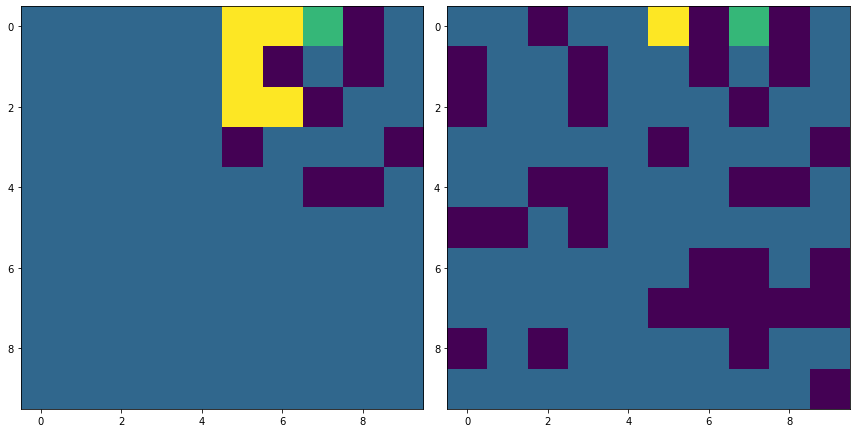

In [27]:
# Maze (10, 10, 3) is a failure
maze = Maze(10, 10, 3)
algorithm = 'forward'
iteration = 5
a, b, c, path, agent_map, state_spawn = forward_a(maze, iteration)
path.pop(0)
print_agent_map(maze, agent_map, path, state_spawn, algorithm)

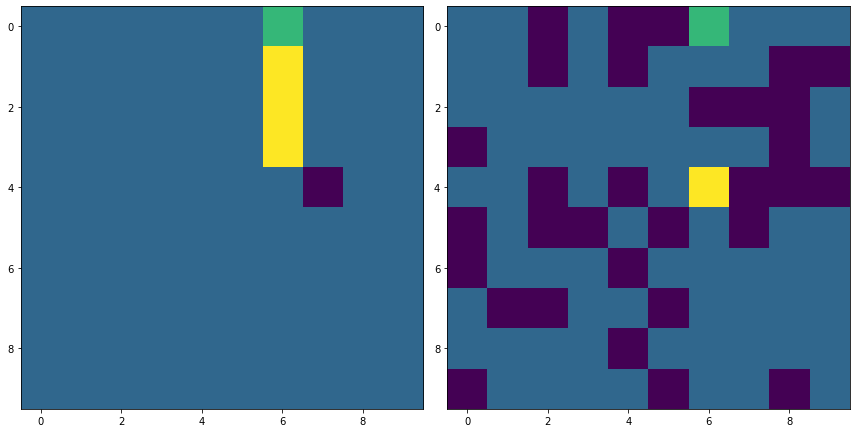

In [184]:
maze = Maze(10, 10, 1)
algorithm = 'backward'
iteration = 1
a, b, c, path, agent_map, state_spawn = backward_a(maze, iteration)
path.pop(0)
print_agent_map(maze, agent_map, path, state_spawn, algorithm)

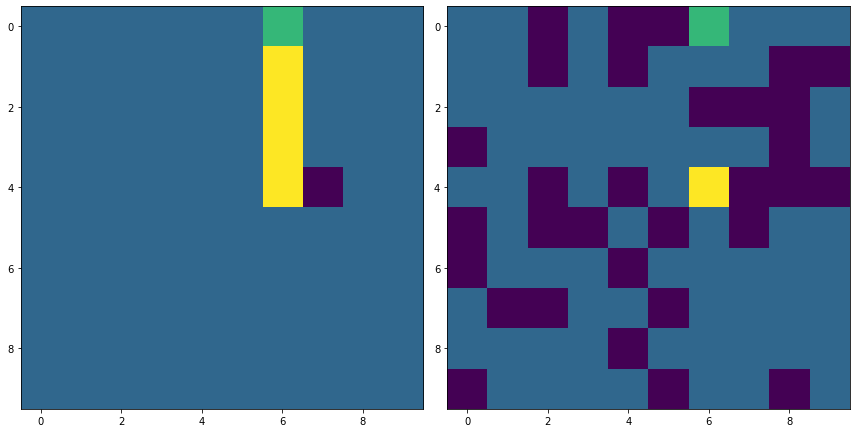

In [186]:
maze = Maze(10, 10, 1)
algorithm = 'adaptive'
iteration = 1
a, b, c, path, agent_map, state_spawn = adaptive_a(maze, iteration)
path.pop(0)
print_agent_map(maze, agent_map, path, state_spawn, algorithm)

In [ ]:
# Test  from Homework

# test_maze = Maze(5, 5, 1)
# test_maze.grid = [[1 for j in range(test_maze.columns)] for i in range(test_maze.rows)]
# test_maze.grid[1][2] = 0
# test_maze.grid[2][2] = 0
# test_maze.grid[3][2] = 0
# test_maze.grid[2][3] = 0
# test_maze.grid[3][3] = 0
# test_maze.grid[4][3] = 0
# test_maze.grid[4][2] = 3
# test_maze.grid[4][4] = 2
# test_maze.spawn = [4, 2]
# test_maze.target = [4, 4]